# Boilerplate

In [1]:
# python internal 
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
print(os.getcwd())
import random
import re
import socket
print(socket.gethostname())
import shutil
import subprocess
import sys
# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta
# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

/mnt/home/pleung/projects/bistable_bundle/r3/hinges
dig141


# Flo's original approach:
5. I design the loops (incl. neighborhood): 
`/home/flop/switch/5thround/DHRs/loops/des*`
(path names kinda match the ones from loop closure)
6. After cleaning up loop neighborhoods with fragment constrained design, stapled using the scripts here `/home/flop/scripts/disulfides/`


# I will follow Flo's suggestion to do a different order of operations.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.

I will rule out designs by packing the loop, then stapling. The staples need to be scored to meet reasonable metrics. 

Adam Moyer suggested `dslf_fa13` of `-0.8` after cartesian relax and minimization. Probably, RMSD after this minimization is a good idea too.  

For matching, will try to always find matches for State X as the initial, parent DHR, as this is the gold standard for a reference state. 
If needed, can use the reclosed parents or the 0 register shifts instead.

# Make functions for looping and labeling to assist downstream penultimate design step

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init
from typing import *

@requires_init
def load(silent: str, **kwargs) -> Generator[str, PackedPose, None]:
    """
    Requires init. Because of some issues with silent energies, if your energy 
    is supposed to be a string but is an empty string  (""),
    it will be set to a float value of 0.0
    @pleung
    """
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.rosetta.core.io.silent import SilentFileOptions, SilentFileData
    from pyrosetta.rosetta.core.pose import Pose
    if silent == None:
        silent = kwargs["-in:file:silent"]
    else:
        pass
    options = SilentFileOptions() 
    sfd = SilentFileData(options) # the part that requires init
    sfd.read_file(silent)
    for tag in sfd.tags():
        ss = sfd.get_structure(tag)
        ss_energies = list(ss.energies())
        pose = Pose()
        ss.fill_pose(pose)
        pose.pdb_info().name(tag)
        for energy in ss_energies:
            key = energy.name() 
            # takes advantage of string_value returning "" for true floats
            if energy.string_value() is not "":
                value = energy.string_value() 
            else: # if your energy is supposed to be an empty string it will be set to 0.0 here
                value = energy.value()
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
        ppose = io.to_packed(pose)
        yield ppose
        
def pack(ppose: PackedPose, **kwargs) -> Generator[str, PackedPose, None]:
    """
    Quickly pack rotamers in new loop with native-like sequence constraints
    """
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    scores = deepcopy(ppose.pose.scores)
    new_loop_resis = scores["new_loop_resis"]
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" >
                <Reweight scoretype="res_type_constraint" weight="1.0" />
            </ScoreFunction> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Index name="new_loop_resis" resnums="{new_loop_resis}" />
            <Neighborhood name="around_new_loop" selector="new_loop_resis" distance="6.0" />
            <Or name="designable" selectors="new_loop_resis,around_new_loop" />
            <Neighborhood name="packable" selector="designable" distance="6.0"/>
            <Not name="not_designable" selector="designable" />
            <Not name="not_packable" selector="packable" />
            <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY" />
            <Layer name="surface" select_core="false" select_boundary="false" select_surface="true"
                use_sidechain_neighbors="true"/>
            <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <Layer name="core" select_core="true" select_boundary="false" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" 
                use_dssp="true" ss="E"/>
            <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" 
                use_dssp="true" ss="L"/>
            <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false"
                use_dssp="true" ss="H"/>
            <And name="helix_cap" selectors="entire_loop">
                <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
            </And>
            <And name="helix_start" selectors="entire_helix">
                <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
            </And>
            <And name="helix" selectors="entire_helix">
                <Not selector="helix_start"/>
            </And>
            <And name="loop" selectors="entire_loop">
                <Not selector="helix_cap"/>
            </And>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <RestrictAbsentCanonicalAAS name="design" keep_aas="ADEFGHIKLMNPQRSTVWY" />
            <OperateOnResidueSubset name="pack" selector="not_designable">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="lock" selector="not_packable">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <DesignRestrictions name="layer_design">
                <Action selector_logic="surface AND helix_start"  aas="DEHKPQR"/>
                <Action selector_logic="surface AND helix"        aas="EHKQR"/>
                <Action selector_logic="surface AND sheet"        aas="EHKNQRST"/>
                <Action selector_logic="surface AND loop"         aas="DEGHKNPQRST"/>
                <Action selector_logic="boundary AND helix_start" aas="ADEHIKLNPQRSTVWY"/>
                <Action selector_logic="boundary AND helix"       aas="ADEHIKLNQRSTVWYM"/>
                <Action selector_logic="boundary AND sheet"       aas="DEFHIKLNQRSTVWY"/>
                <Action selector_logic="boundary AND loop"        aas="ADEFGHIKLNPQRSTVWY"/>
                <Action selector_logic="core AND helix_start"     aas="AFILVWYNQSTHP"/>
                <Action selector_logic="core AND helix"           aas="AFILVWM"/>
                <Action selector_logic="core AND sheet"           aas="FILVWY"/>
                <Action selector_logic="core AND loop"            aas="AFGILPVWYSM"/>
                <Action selector_logic="helix_cap"                aas="DNSTP"/>
            </DesignRestrictions>
            <PruneBuriedUnsats name="prune" allow_even_trades="false" 
                atomic_depth_cutoff="3.5" minimum_hbond_energy="-1.0"/>
            <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
        </TASKOPERATIONS>
        <MOVERS>
            <StructProfileMover name="gen_profile" add_csts_to_pose="1" consider_topN_frags="100" 
                eliminate_background="0" ignore_terminal_residue="1" only_loops="0"
                residue_selector="designable" burialWt="0" RMSthreshold="0.6" />
            <ClearConstraintsMover name="clear_constraints" />
            <PackRotamersMover name="pack"
            task_operations="arochi,prune,ex1_ex2,design,pack,lock,layer_design"/>
        </MOVERS>
        <PROTOCOLS>
            <Add mover="gen_profile"/>
            <Add mover="pack"/>
            <Add mover="clear_constraints"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(new_loop_resis=new_loop_resis)
    pack = SingleoutputRosettaScriptsTask(xml)
    pack_ppose = pack(ppose.pose.clone())
    pose = io.to_pose(pack_ppose)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    final_ppose = io.to_packed(pose)
    yield final_ppose
        
def staple(ppose: PackedPose, **kwargs) -> list:
    """
    Try find a native disulfide connection. 
    Do increasingly larger normal modes perturbation each time it can't find one.
    Start at 3 normal modes and increase up to 12. Perturbation scale is 1.6.
    TODO assumes middle is where the switch is split originally
    """
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects
    from stapler import NativeDisulfideStapler
    scores = deepcopy(ppose.pose.scores)
    pose = io.to_pose(ppose.pose.clone())
    new_loop_resis = [int(x) for x in scores["new_loop_resis"].split(",")]
    new_loop_resis.sort()
    print("new loop found at indices", new_loop_resis)
    upper_A = new_loop_resis[0] - 4
    lower_B = new_loop_resis[-1] + 4
    try:
        assert upper_A > 0
        assert lower_B < len(pose.residues)
    except AssertionError:
        print("the new loop resis are unexpectedly close to the termini")
    selectors = XmlObjects.create_from_string(
        """
        <RESIDUE_SELECTORS>
            <SSElement name="first" selection="n_term" to_selection="{pre},H,E" chain="A" reassign_short_terminal_loop="2" />
            <SSElement name="second" selection="{post},H,S" to_selection="c_term" chain="A" reassign_short_terminal_loop="2" />
        </RESIDUE_SELECTORS>
        """.format(
            pre = int(scores["pre_break_helix"]),
            post = int(scores["pre_break_helix"]+1)
        )
    )
    first = selectors.get_residue_selector("first")
    second = selectors.get_residue_selector("second")
    first_resis = list(first.apply(pose))
    second_resis = list(second.apply(pose))
    chunk_A = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
    chunk_B = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
    offset = 3 # distance we want to stay away from new loop
    length = len(pose.residues)
    assert length == scores["total_length"] 
    for i, index_bool in enumerate(first_resis, start=1):
        # don't add residues within offset distance before new loop
        if index_bool and i < (sum(first_resis) - offset):
            chunk_A.append_index(i)
        else:
            pass
    for i, index_bool in enumerate(second_resis, start=1):
        first = 0
        # don't add residues within offset distance after new loop
        if index_bool and i > (sum(1 for x in second_resis if not x) + offset):
            chunk_B.append_index(i)
        else:
            pass
    not_too_close = [chunk_B, chunk_A]
    
    new_loop_resis = scores["new_loop_resis"]
    
    # initialize the native disulfide stapler with defaults.
    stapler = NativeDisulfideStapler(
        residue_selectors = not_too_close,
    )
    i = 0
    for i in range(10):
        crosslinked_poses = stapler.apply(pose) # this returns a generator
        try: # peek inside the generator to see if it is empty
            peek = next(crosslinked_poses) # raises StopIteration exception if empty
            break # break out of the loop if it isn't empty
        except StopIteration: # perform normal modes relax if StopIteration exception occurs
            xml = """
            <ROSETTASCRIPTS>
                <SCOREFXNS>
                <ScoreFunction name="sfxn" weights="beta_nov16"/>
                <ScoreFunction name="sfxn_bb_perterb" weights="beta_nov16">
                    <Reweight scoretype="coordinate_constraint" weight="5.0"/> #play with this
                </ScoreFunction>
                </SCOREFXNS>
                <RESIDUE_SELECTORS>
                    <True name="all"/>
                    <SSElement name="design" selection="{pre},H,S" to_selection="-{post},H,E" chain="A" reassign_short_terminal_loop="2" />            
                    <Not name="not_design" selector="design"/>
                    <Neighborhood name="pack" selector="design" distance="8.0" include_focus_in_subset="0"/>
                    <Not name="not_pack" selector="pack"/>
                    <And name="lock_selector" selectors="not_pack,not_design"/>
                </RESIDUE_SELECTORS>
                <TASKOPERATIONS>
                    <OperateOnResidueSubset name="lock" selector="lock_selector">
                        <PreventRepackingRLT/>
                    </OperateOnResidueSubset>
                </TASKOPERATIONS>
                <MOVERS>
                    <NormalModeRelax name="normal_modes"
                        cartesian="true"
                        centroid="false"
                        nmodes="{nmodes}"
                        scorefxn="sfxn"
                        mix_modes="true"
                        pertscale="1.6"
                        randomselect="true"
                        relaxmode="relax"
                        cartesian_minimize="false" >
                        <MoveMap name="mm" bb="false" chi="false" jump="false" >
                            <ResidueSelector selector="all" bb="false" chi="false" />
                            <ResidueSelector selector="pack" bb="false" chi="true" />
                            <ResidueSelector selector="design" bb="true" chi="true" />
                        </MoveMap>
                    </NormalModeRelax>
                </MOVERS>
                <PROTOCOLS>
                    <Add mover="normal_modes"/>
                </PROTOCOLS>
            </ROSETTASCRIPTS>
            """.format(
                pre = int(scores["pre_break_helix"]-1),
                post = int(scores["pre_break_helix"]-1),
                nmodes = int(3+i), # increase number of normal modes each iteration
            )
            normal_modes = SingleoutputRosettaScriptsTask(xml)
            pose = io.to_pose(normal_modes(pose))
    nmodes_attempts = float(i)
    name = pose.pdb_info().name()
    poses = []
    sfxn = pyrosetta.rosetta.protocols.loops.get_fa_scorefxn()
    i = 0
    for i, crosslinked_pose in enumerate(crosslinked_poses):
        suffix = "_" + str(i)
        crosslinked_pose.pdb_info().name(name+suffix)
        disulfide = []
        for j, aa in enumerate(crosslinked_pose.sequence(), start=1):
            if aa == "C":
                disulfide.append(str(j))
            else:
                pass
        assert len(disulfide) == 2
        disulfide_str = ",".join(disulfide)
        pyrosetta.rosetta.core.pose.setPoseExtraScore(crosslinked_pose, "disulfide_at", disulfide_str)
        pyrosetta.rosetta.core.pose.setPoseExtraScore(crosslinked_pose, "nmodes_attempts", nmodes_attempts)
        rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
        rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
        rmsd_calc.set_run_superimpose(True)
        rmsd_calc.set_comparison_pose(pose)
        rmsd = rmsd_calc.calculate(crosslinked_pose)
        pyrosetta.rosetta.core.pose.setPoseExtraScore(crosslinked_pose, "rmsd_nmp", rmsd)
        for key, value in scores.items():
            pyrosetta.rosetta.core.pose.setPoseExtraScore(crosslinked_pose, key, value)
        poses.append(crosslinked_pose)
    if len(poses) > 0:
        final_pposes = io.to_packed(set(poses))
    else: # just return the original pose if it fails
        pose = io.to_pose(ppose.pose.clone())
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "disulfide_at", "0,0")        
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "nmodes_attempts", nmodes_attempts)
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "rmsd_nmp", 0.0)
        final_pposes = io.to_packed({pose})
    return final_pposes

def check_disulf_energy(ppose: PackedPose, **kwargs) -> PackedPose:
    """
    relax the pose around the interface in cartesian space, but don't save it, keep the original pose,
    get the cartesian-relaxed disulfide scores and rmsd, 
    and add them the original pose with the original scores
    TODO assumes middle is where the switch is split originally
    @pleung
    """
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    scores = deepcopy(ppose.pose.scores)
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn_cart" weights="ref2015_cart" /> 
            <ScoreFunction name="sfxn" weights="ref2015" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <True name="all"/>
            <SSElement name="design" selection="{pre},H,S" to_selection="-{post},H,E" chain="A" reassign_short_terminal_loop="2" />            
            <Not name="not_design" selector="design"/>
            <Neighborhood name="pack" selector="design" distance="8.0" include_focus_in_subset="0"/>
            <Not name="not_pack" selector="pack"/>
            <And name="lock_selector" selectors="not_pack,not_design"/>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <PruneBuriedUnsats name="prune" allow_even_trades="false" 
                atomic_depth_cutoff="3.5" minimum_hbond_energy="-1.0"/>
            <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
            <OperateOnResidueSubset name="lock" selector="lock_selector">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
        </TASKOPERATIONS>
        <FILTERS>
            <Rmsd name="rmsd_cart" reference_name="before_relax" chains="A" superimpose="1" threshold="5" by_aln="0" confidence="0" />
        </FILTERS>
        <MOVERS>
            <SavePoseMover name="save_before_relax" restore_pose="0" reference_name="before_relax"/>
            <FastRelax name="relax" scorefxn="sfxn_cart"
                task_operations="arochi,prune,ex1_ex2,lock"
                repeats="2" 
                relaxscript="MonomerRelax2019"
                cartesian="true"
                bondangle="true"
                bondlength="true" >
                    <MoveMap name="mm" bb="false" chi="false" jump="false" >
                        <ResidueSelector selector="all" bb="false" chi="false" bondangle="false" bondlength="false" />
                        <ResidueSelector selector="pack" bb="false" chi="true" bondangle="true" bondlength="true" />
                        <ResidueSelector selector="design" bb="true" chi="true" bondangle="true" bondlength="true" />
                    </MoveMap>
            </FastRelax>
        </MOVERS>
        <PROTOCOLS>
            <Add mover="save_before_relax" />
            <Add mover="relax" />            
            <Add filter="rmsd_cart" />            
        </PROTOCOLS>
        <OUTPUT scorefxn="sfxn" />
    </ROSETTASCRIPTS>
    """.format(
        pre = int(scores["pre_break_helix"]-1),
        post = int(scores["pre_break_helix"]-1)
    )
    relax = SingleoutputRosettaScriptsTask(xml)
    # relax the pose to get scores
    relax_ppose = relax(ppose.pose.clone())
    # keep the original pose...
    pose = io.to_pose(ppose)
    # ... get the cartesian-relaxed disulfide scores and rmsd...
    update = deepcopy(relax_ppose.pose.scores)
    dslf_fa13_cart = update["dslf_fa13"]
    rmsd_cart = update["rmsd_cart"]
    # ... add the original scores ...
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    # ... and finally add the cartesian-relaxed disulfide scores and rmsd
    pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "dslf_fa13_cart", dslf_fa13_cart)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "rmsd_cart", rmsd_cart)
    final_ppose = io.to_packed(pose)
    return final_ppose

def relax(ppose: PackedPose, **kwargs) -> PackedPose:
    """
    dualspace relax, check rmsd and fragment quality and return scored ppose
    geometry filter counts bad residues.
    TODO assumes middle is where the switch is split originally
    @pleung
    """
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    scores = deepcopy(ppose.pose.scores)
    new_loop_resis = scores["new_loop_resis"]
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
            <ScoreFunction name="sfxn_cart" weights="beta_nov16_cart" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <True name="all"/>
            <ResidueName name="CYS" residue_name3="CYS" />
            <Not name="not_CYS" selector="CYS" />
            <Index name="new_loop_resis" resnums="{new_loop_resis}" />
            <Neighborhood name="around_new_loop" selector="new_loop_resis" distance="8.0" />
            <SSElement name="design" selection="{pre},H,S" to_selection="-{post},H,E" chain="A" reassign_short_terminal_loop="2" />            
            <Not name="not_design" selector="design"/>
            <Neighborhood name="pack" selector="design" distance="8.0" include_focus_in_subset="0"/>
            <Not name="not_pack" selector="pack"/>
            <And name="lock_selector" selectors="not_pack,not_design"/>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <PruneBuriedUnsats name="prune" allow_even_trades="false" 
                atomic_depth_cutoff="3.5" minimum_hbond_energy="-1.0"/>
            <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
            <OperateOnResidueSubset name="lock" selector="lock_selector">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
        </TASKOPERATIONS>
        <FILTERS>
            <Geometry name="geometry"
            confidence="0"
            count_bad_residues="true" />
            <Geometry name="geometry_loop" 
            residue_selector="around_new_loop" 
            confidence="0"
            count_bad_residues="true" />
            <Rmsd name="rmsd_dual" reference_name="before_relax" chains="A" superimpose="1" threshold="5" by_aln="0" confidence="0" />
            <worst9mer name="9mer" rmsd_lookup_threshold="0.4" confidence="0" />
        </FILTERS>
        <MOVERS>
            <SavePoseMover name="save_before_relax" restore_pose="0" reference_name="before_relax"/>
            <FastRelax name="relax" scorefxn="sfxn_cart"
                task_operations="arochi,prune,ex1_ex2,lock"
                repeats="2" 
                relaxscript="MonomerRelax2019"
                dualspace="true"
                bondangle="true"
                bondlength="true" >
                <MoveMap name="mm" bb="false" chi="false" jump="false" >
                    <ResidueSelector selector="all" bb="false" chi="false" bondangle="false" bondlength="false" />
                    <ResidueSelector selector="pack" bb="false" chi="true" bondangle="false" bondlength="false" />
                    <ResidueSelector selector="design" bb="true" chi="true" bondangle="false" bondlength="false" />
                    <ResidueSelector selector="CYS" bb="true" chi="true" bondangle="true" bondlength="true" />
                </MoveMap>
            </FastRelax>
        </MOVERS>
        <PROTOCOLS>
            <Add mover="save_before_relax" />
            <Add mover="relax" />
            <Add filter="geometry" />
            <Add filter="geometry_loop" />
            <Add filter="rmsd_dual" />
            <Add filter="9mer" />
        </PROTOCOLS>
        <OUTPUT scorefxn="sfxn" />
    </ROSETTASCRIPTS>
    """.format(
        new_loop_resis=new_loop_resis,
        pre = int(scores["pre_break_helix"]-1),
        post = int(scores["pre_break_helix"]-1)
    )
    # relax and score pose
    relax = SingleoutputRosettaScriptsTask(xml)
    relax_ppose = relax(ppose.pose.clone())
    pose = io.to_pose(relax_ppose)
    update = deepcopy(pose.scores)
    # update scores for values that were updated
    for key, value in scores.items():
        if key in update.keys():
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, update[key])
        else:
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    final_ppose = io.to_packed(pose)
    return final_ppose

# Setup Dask
Trying a adaptive SLURMCluster. to see the dashboard, forward port `8787` to `8000`:  
`local$ ssh -L 8000:localhost:8787 $USER@$HOSTNAME`  
now, the web UI is visible at `localhost:8000`  
if you're using a local cluster make sure the node this notebook is on has the same 
number of workers as cores

In [3]:
!echo $HOSTNAME
!echo $USER

dig141
pleung


In [4]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       processes=1,
                       job_cpu=1,
                       memory="7GB",
                       queue="medium",
                       walltime="23:55:00",
                       death_timeout=600,
                      )
print(cluster.job_script())
# scale between 0 and 200 workers as needed
cluster.adapt(minimum=0, maximum=200, wait_count=500) 
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=7G
#SBATCH -t 23:55:00

/home/pleung/.conda/envs/cereal/bin/python -m distributed.cli.dask_worker tcp://172.16.131.245:44831 --nthreads 1 --memory-limit 7.00GB --name name --nanny --death-timeout 600 --local-directory $TMPDIR/dask



<Client: 'tcp://172.16.131.245:44831' processes=0 threads=0, memory=0 B>

In [5]:
# client.close(); cluster.close()

# Set command line options, make tasks and submit to client
Seperately try to staple reference poses. Hopefully 100% stapled by Stapler

In [6]:
import logging
import pyrosetta.distributed.io as io
from pyrosetta.distributed.cluster.core import PyRosettaCluster
logging.basicConfig(level=logging.INFO)

silents = glob(os.path.join(os.getcwd(), "03_silents/originals.silent"))

options = { 
    "-out:level": "300",
    "-in:file:silent_struct_type": "binary",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-dunbrack_prob_buried": "0.8",
    "-dunbrack_prob_nonburied": "0.8", 
    "-dunbrack_prob_buried_semi": "0.8", 
    "-dunbrack_prob_nonburied_semi": "0.8",
}

def create_tasks(silents, options):
    for silent in silents:
        tasks = {"options": "-corrections::beta_nov16 true"}
        tasks["extra_options"] = options
        tasks["set_logging_handler"] = "interactive"
        tasks["-in:file:silent"] = silent
        yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "04_pack_staple_ref")
    PyRosettaCluster(
        tasks=create_tasks(silents, options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
        seeds=[1, 1, 1, 1, 1],        
    ).distribute(protocols=[load, pack, staple, check_disulf_energy, relax])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


https://docs.anaconda.com/anaconda/install



# Now do states and restored loops
previously used `-indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5`

In [ ]:
logging.basicConfig(level=logging.INFO)
silents = glob(os.path.join(os.getcwd(), "03_silents/*closed.silent"))

options = { 
    "-out:level": "300",
    "-in:file:silent_struct_type": "binary",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-dunbrack_prob_buried": "0.8",
    "-dunbrack_prob_nonburied": "0.8", 
    "-dunbrack_prob_buried_semi": "0.8", 
    "-dunbrack_prob_nonburied_semi": "0.8",
}

def create_tasks(silents, options):
    for silent in silents:
        tasks = {"options": "-corrections::beta_nov16 true"}
        tasks["extra_options"] = options
        tasks["set_logging_handler"] = "interactive"
        tasks["-in:file:silent"] = silent
        yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "04_pack_staple_pair")
    PyRosettaCluster(
        tasks=create_tasks(silents, options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
        seeds=[1, 1, 1, 1, 1],        
    ).distribute(protocols=[load, pack, staple, check_disulf_energy, relax])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


# Look at scores
There is certainly a less embarrassing way to do this but at least this way is vectorized, so it should scale very well

In [7]:
def read_scorefile(scores):
    import pandas as pd
    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores
    
output_path = os.path.join(os.getcwd(), "04_pack_staple_pair")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

9mer  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  0.829566   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  0.504347   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  0.877367   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  0.277829   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  1.017222   

                                                                                            abego_str  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAABAB...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  XAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAGBBAAAA...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  XAAAAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAAA...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAABABAAAAA...   

                                                        bb_clash  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...     50.251999   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...     55.573002   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...     50.632999   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...     59.459999   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  12329.072266   

                                                      closure_type  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  strict_remodel   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  strict_remodel   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  strict_remodel   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...      loop_match   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  strict_remodel   

                                                           ddg disulfide_at  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -88.988998       32,131   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -94.186996        75,97   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -77.867996       59,102   
/mnt/home/pleung/projects/bistable_bundle/r3/hi... -109.612999          0,0   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -94.197998       69,111   

                                                    dslf_fa13  dslf_fa13_cart  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -0.200645       -0.297279   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -1.004656       -1.139828   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -0.745111       -0.314772   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...   0.000000        0.000000   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  -0.649917       -0.534860   

                                                                                                 dssp  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  LHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHHHHHLLL...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  LHHHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHHHLLLHHHH...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  LHHHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHHLLHHH...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  LHHHHHHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHHHHHHH...   
/mnt/home/pleung/projects/bistable_bundle/r3/hi...  LHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHLLLLHHHHH...   

                                                         fa_atr  ...  sc_int  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi... -1148.801743  ...   0.713   
/mnt/home/pleung/projects/bistable_bundle/r3/hi... -1081.224113  ...   0.746   
/mnt/home/pleung/projects/bistable_bundle/r3/hi... -1065.395756  ...   0.785   
/mnt/home/pleung/projects/bistable_bundle/r3/hi... -1283.866012  ...   0.737   
/mnt/home/pleung/projects/bistable_bundle/r3/hi... -1046.269343  ...   0.844   

                                                    scaffold  score  \
/mnt/home/pleung/projects/bistable_bundle/r3/hi...       DHR    0

In [8]:
len(scores_df)

5193

# Add reference states

In [12]:
output_path = os.path.join(os.getcwd(), "04_pack_staple_ref")
ref = os.path.join(output_path, "scores.json")
ref_df = read_scorefile(ref)
print(len(ref_df))
# sanity check
set(ref_df.columns)-set(scores_df.columns)

129


{'fa_dun',
 'fa_intra_rep',
 'lk_ball_wtd',
 'nmodes_attempts',
 'rmsd_nmp',
 'stapled',
 'yhh_planarity'}

In [24]:
import bz2

f1 = "/mnt/home/pleung/projects/bistable_bundle/r3/hinges/04_pack_staple_pair/decoys/0000/2021.02.18.00.12.08.841005_327af4aa97684c8ab9d4fc2d5420c59a.pdb.bz2"
f2 = "/mnt/home/pleung/projects/bistable_bundle/r3/hinges/04_pack_staple_pair/decoys/0000/2021.02.18.00.12.08.841005_0ed3b846c34b4436ae44760a22b694d6.pdb.bz2"
p1, p2 = io.pose_from_pdbstring(bz2.decompress(open(f1, "rb").read()).decode()), io.pose_from_pdbstring(bz2.decompress(open(f2, "rb").read()).decode())

In [39]:
# pyrosetta.rosetta.core.scoring.superimpose_pose(p1.pose, p2.pose)
rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
rmsd_calc.set_run_superimpose(True)
rmsd_calc.set_comparison_pose(p1.pose)
rmsd_calc.calculate(p1.pose)

9.999999987757249e-08

# Weird, need to resolve differences

In [10]:
ref_df = ref_df[scores_df.columns]
set(ref_df.columns)-set(scores_df.columns)

set()

In [13]:
scores_df.columns

Index(['9mer', 'abego_str', 'bb_clash', 'closure_type', 'ddg', 'disulfide_at',
       'dslf_fa13', 'dslf_fa13_cart', 'dssp', 'fa_atr', 'fa_dun_dev',
       'fa_dun_rot', 'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4',
       'fa_intra_elec', 'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep',
       'fa_sol', 'geometry', 'geometry_loop', 'hbond_bb_sc', 'hbond_lr_bb',
       'hbond_sc', 'hbond_sr_bb', 'hxl_tors', 'interface_buried_sasa',
       'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl', 'lk_ball_iso',
       'new_loop_resis', 'omega', 'p_aa_pp', 'parent', 'parent_length',
       'pivot_helix', 'pre_break_helix', 'pro_close', 'rama_prepro', 'ref',
       'rmsd_cart', 'rmsd_dual', 'sc', 'sc_int', 'scaffold', 'score',
       'score_A', 'score_B', 'score_per_res', 'sfxn_used', 'shift',
       'total_length', 'total_score'],
      dtype='object')

In [15]:
scores_df["stapled"] = scores_df["disulfide_at"].apply(lambda x: "True" if (x != "0,0") else "False")
ref_df["stapled"] = ref_df["disulfide_at"].apply(lambda x: "True" if (x != "0,0") else "False")

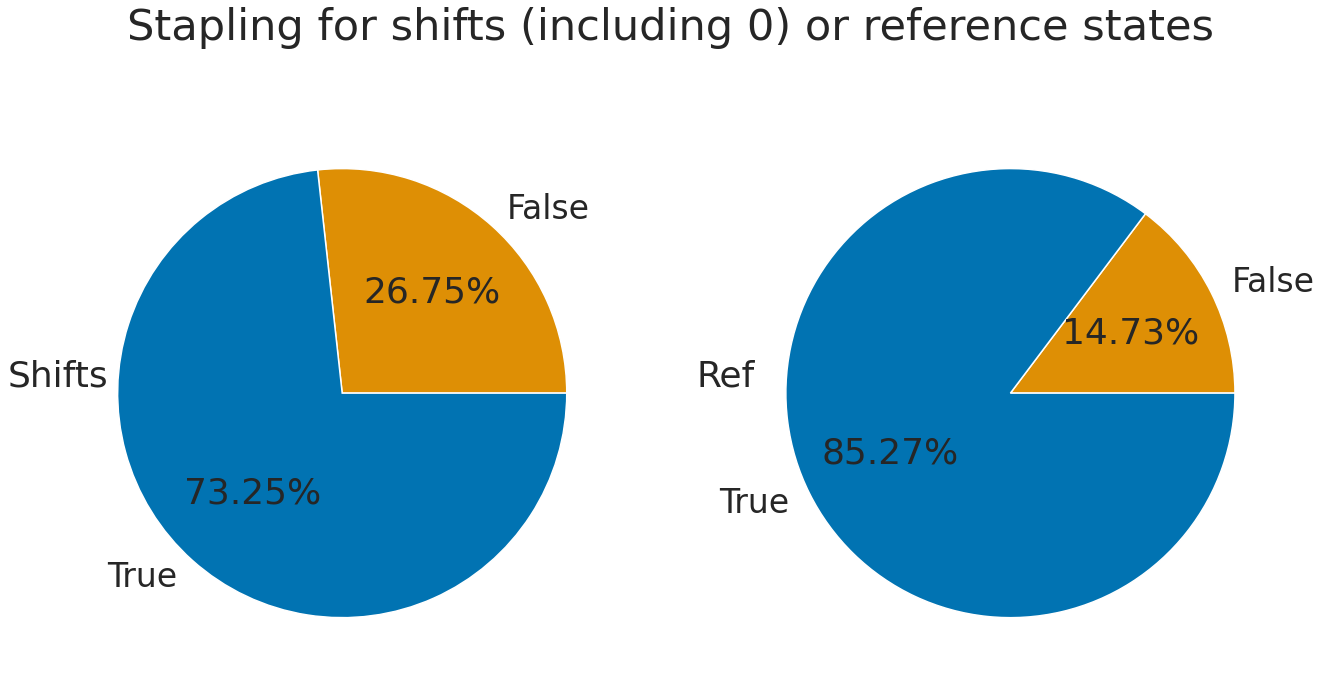

In [16]:
sns.set(
    context="talk",
    font_scale=2, # make the font larger; default is pretty small
    style="ticks", # make the background white with black lines
    palette="colorblind" # a color palette that is colorblind friendly!
)
palette = list(sns.color_palette("colorblind", 256).as_hex())
palette = palette[:2]
palette.reverse()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("stapled").size().plot(kind="pie", autopct="%1.2f%%", colors=palette, ax=ax1)
ref_df.groupby("stapled").size().plot(kind="pie", autopct="%1.2f%%", colors=palette, ax=ax2)
ax1.set_ylabel("Shifts", rotation=0)
ax2.set_ylabel("Ref", rotation=0)
plt.suptitle("Stapling for shifts (including 0) or reference states")
plt.savefig("figs/04_stapling_rate.png")

Total stapled:
0
After removing crazy outliers:
129


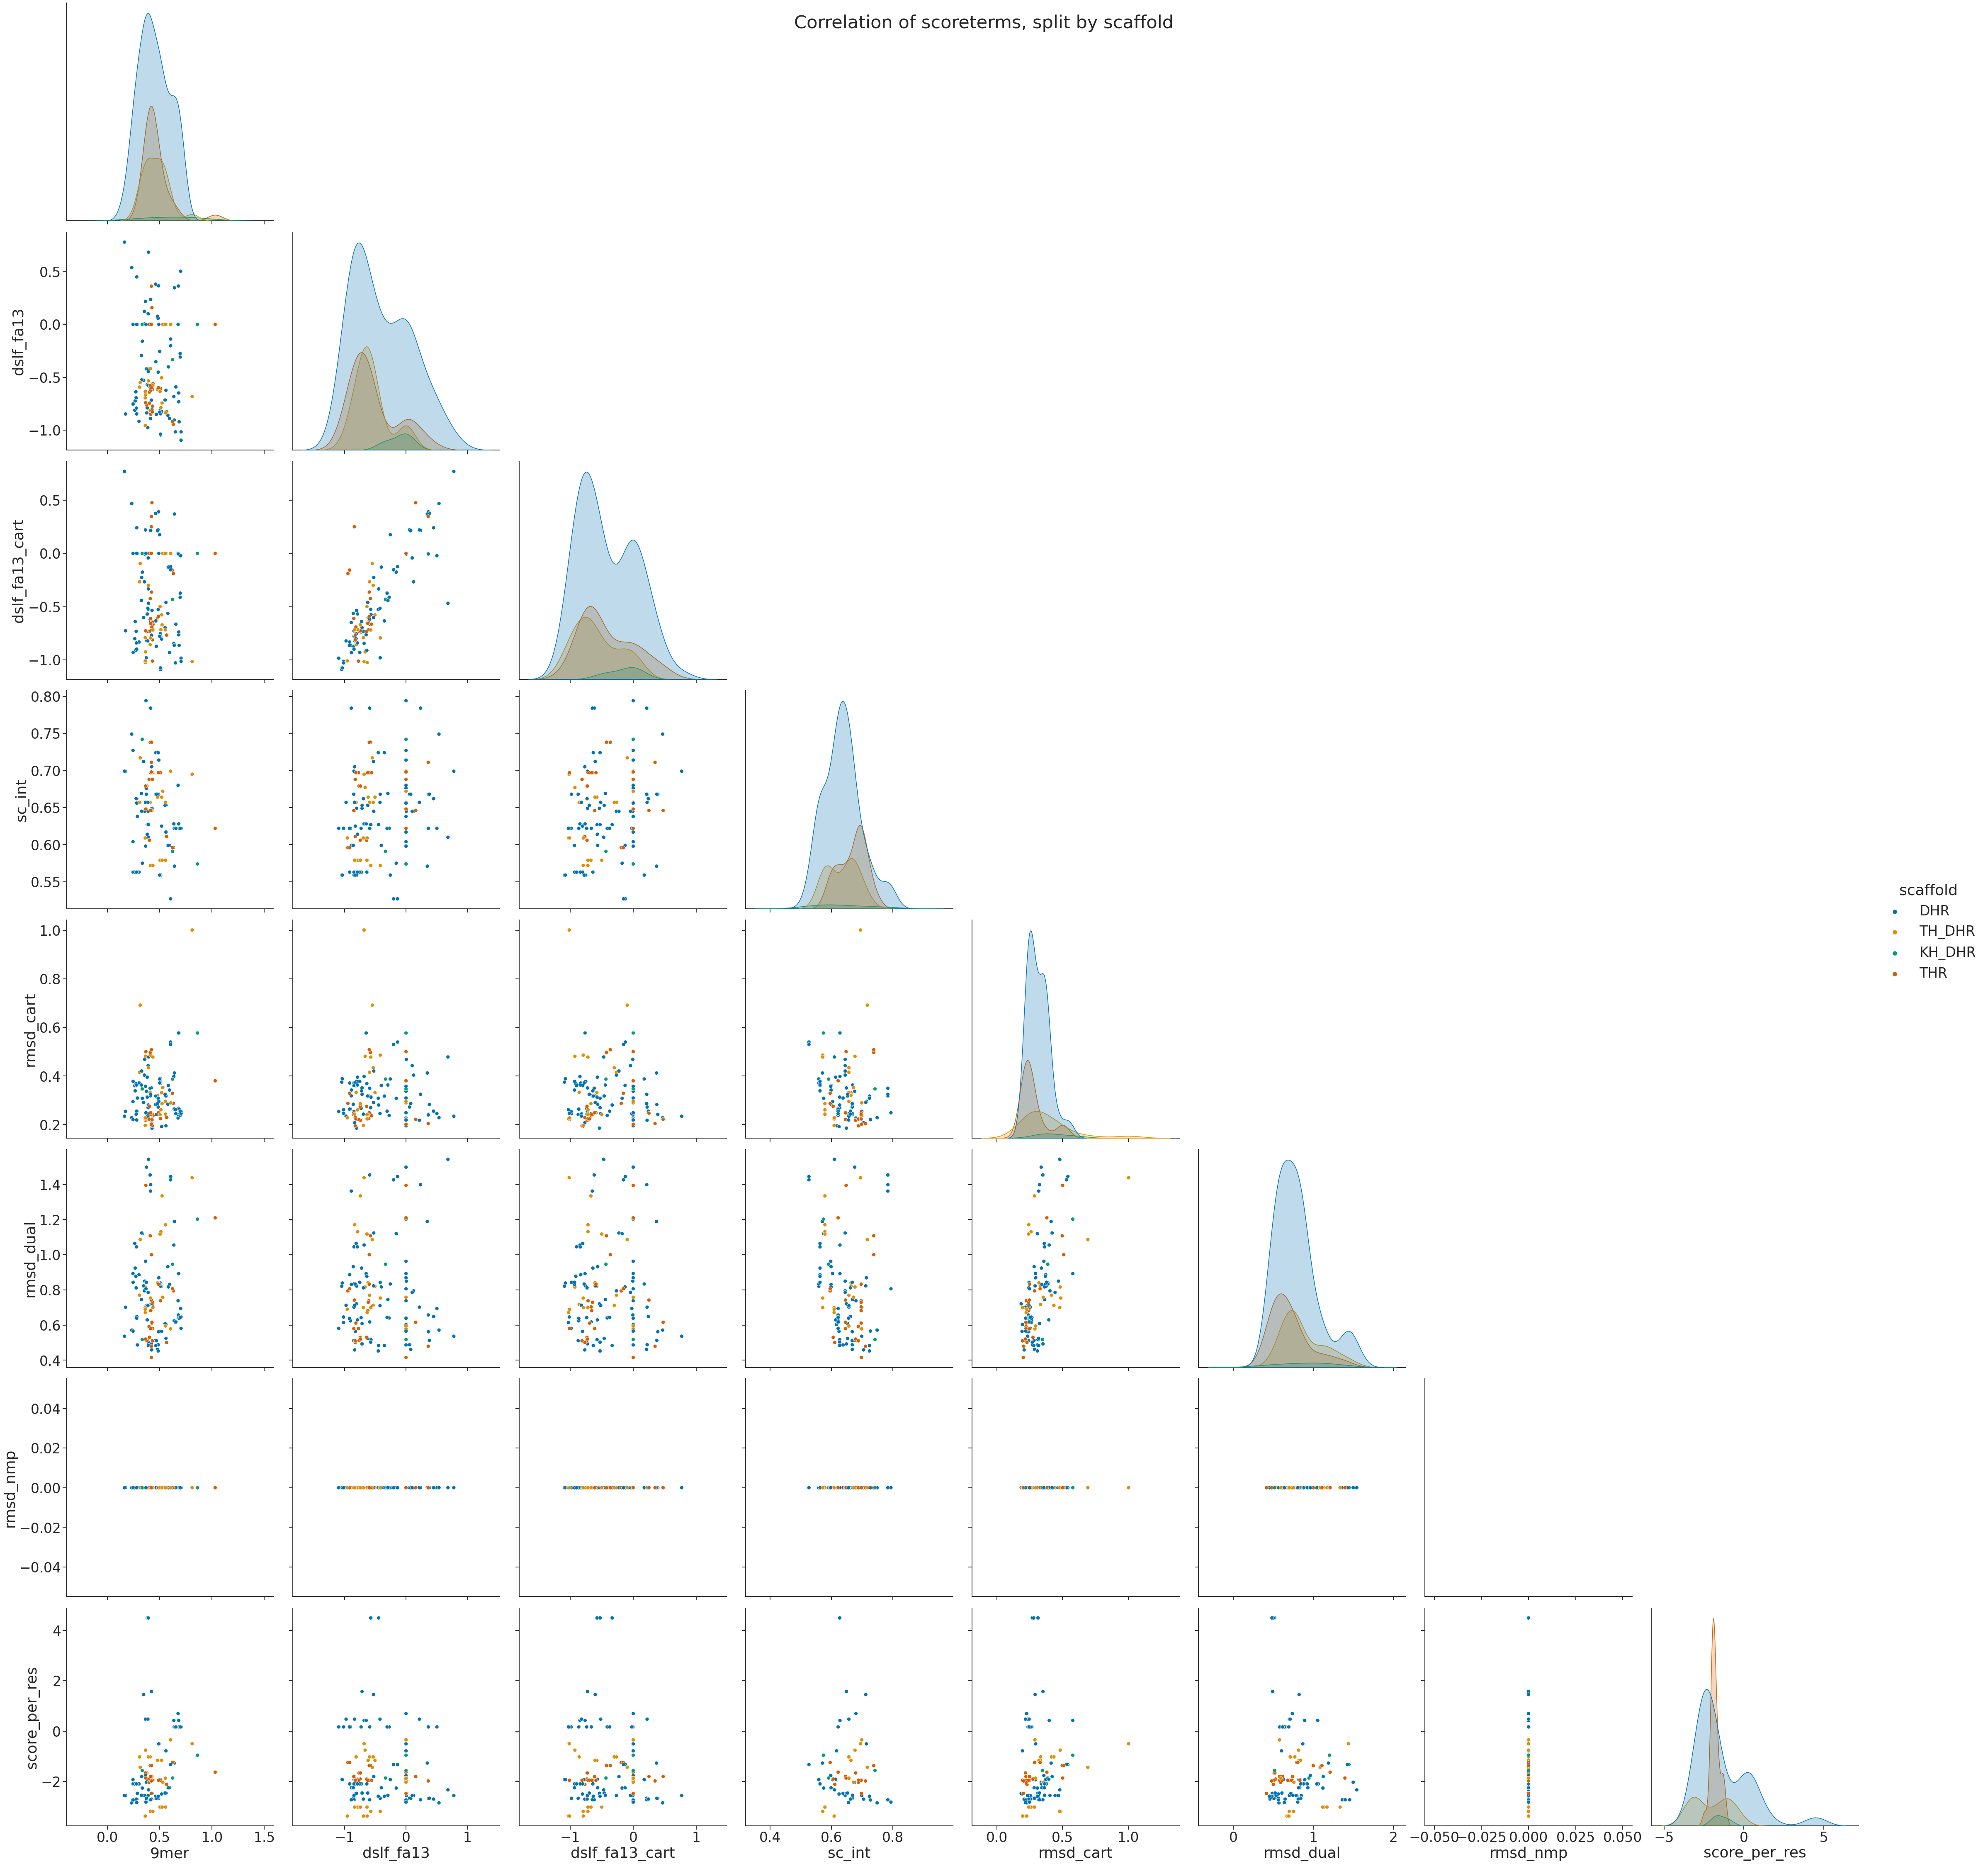

In [18]:
score_subset = ref_df[ # TODO
    [
        "9mer",
        "dslf_fa13",
        "dslf_fa13_cart",
#         "geometry",
#         "geometry_loop",
        "nmodes_attempts",
        "sc_int",
        "rmsd_cart",
        "rmsd_dual",
        "rmsd_nmp",
        "score_per_res",
        "scaffold",
#         "stapled"
    ]
]
# score_subset = score_subset[score_subset["9mer"] < 5] # don't want to plot the decoys with really bad 9mers
# score_subset = score_subset[score_subset["dslf_fa13"] != 0] # don't want to plot the decoys with no disulfides
# score_subset = score_subset[score_subset["dslf_fa13"] < 3] # don't want to plot the decoys with really bad disulfides
# score_subset = score_subset[score_subset["dslf_fa13_cart"] < 3] # don't want to plot the decoys with really bad disulfides
# score_subset = score_subset[score_subset["rmsd_dual"] < 20] # i messed this up
# score_subset = score_subset[score_subset["rmsd_cart"] < 1.5] # don't want to plot the decoys with really bad disulfides

print("Total stapled:")
print(len(scores_df[scores_df["stapled"] == True]))
print("After removing crazy outliers:")
print(len(score_subset))

ax = sns.pairplot(data=score_subset, hue="scaffold", corner=True, height=8)
plt.suptitle("Correlation of scoreterms, split by scaffold")
sns.despine()
# plt.savefig("figs/04_correlations_split_by_scaffold.png")

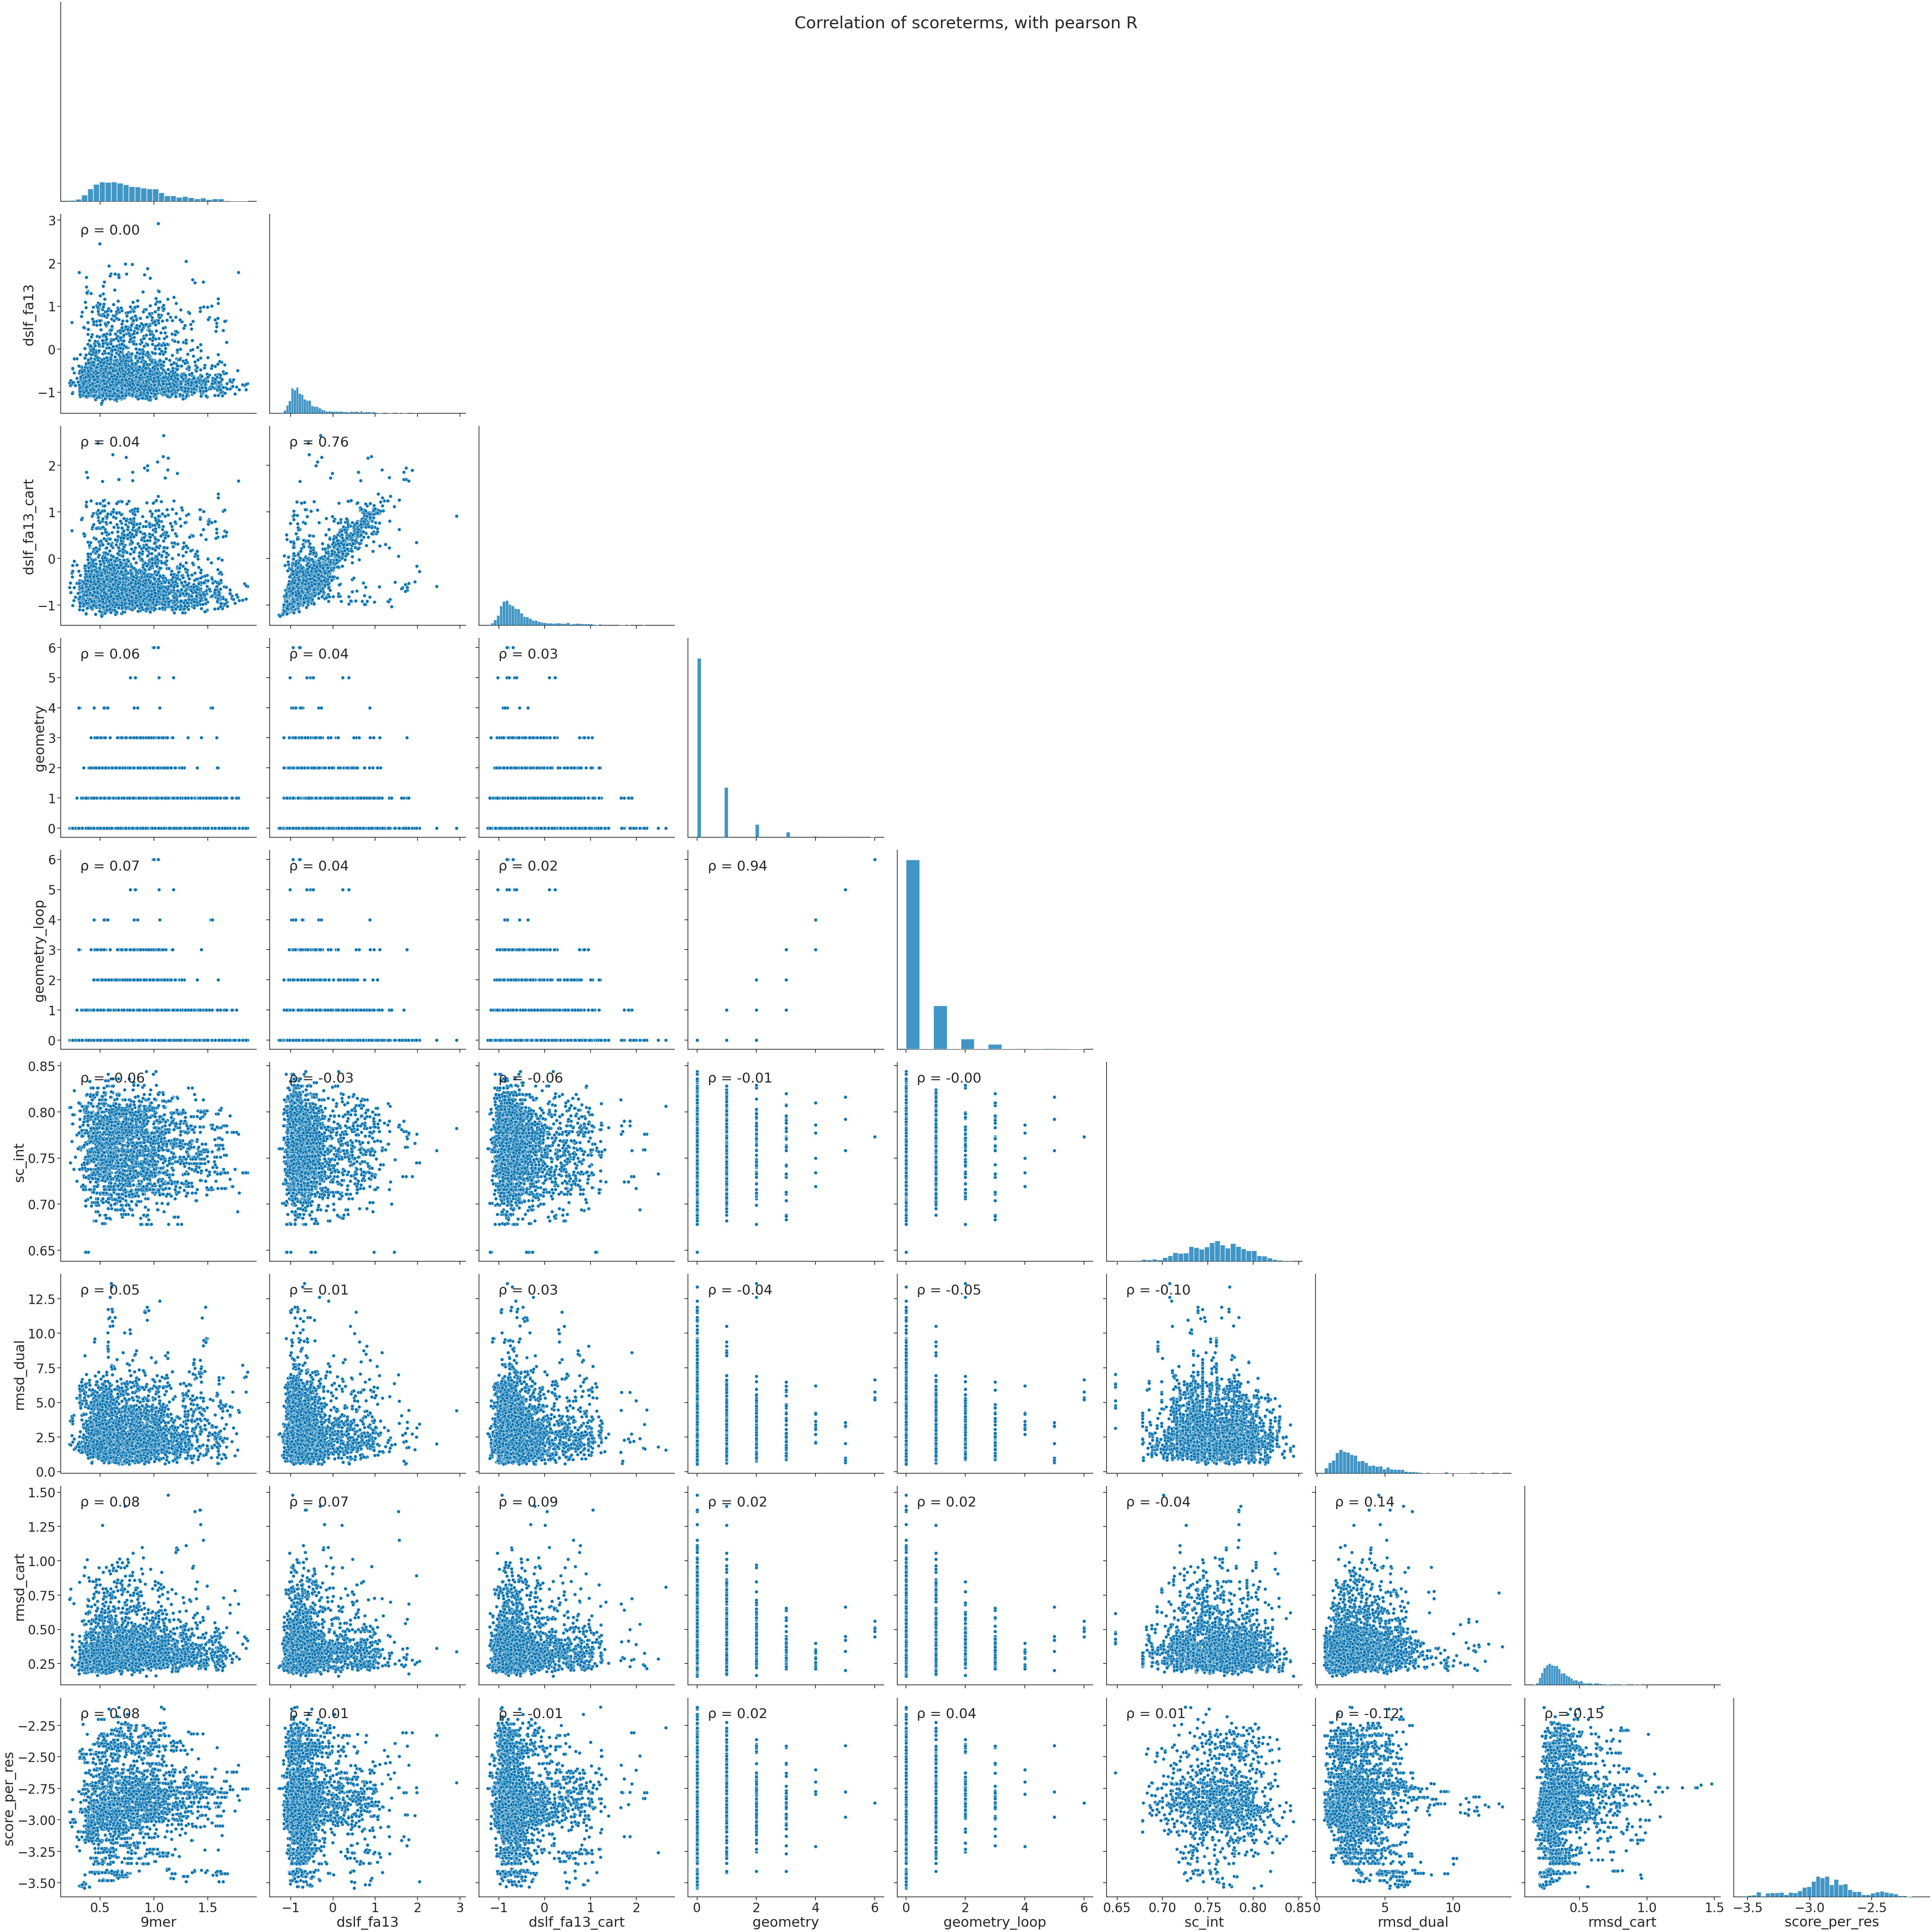

In [47]:
def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy
    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ) 
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes)

ax = sns.pairplot(data=score_subset, corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of scoreterms, with pearson R")
sns.despine()
plt.savefig("figs/04_correlations_pearson.png")

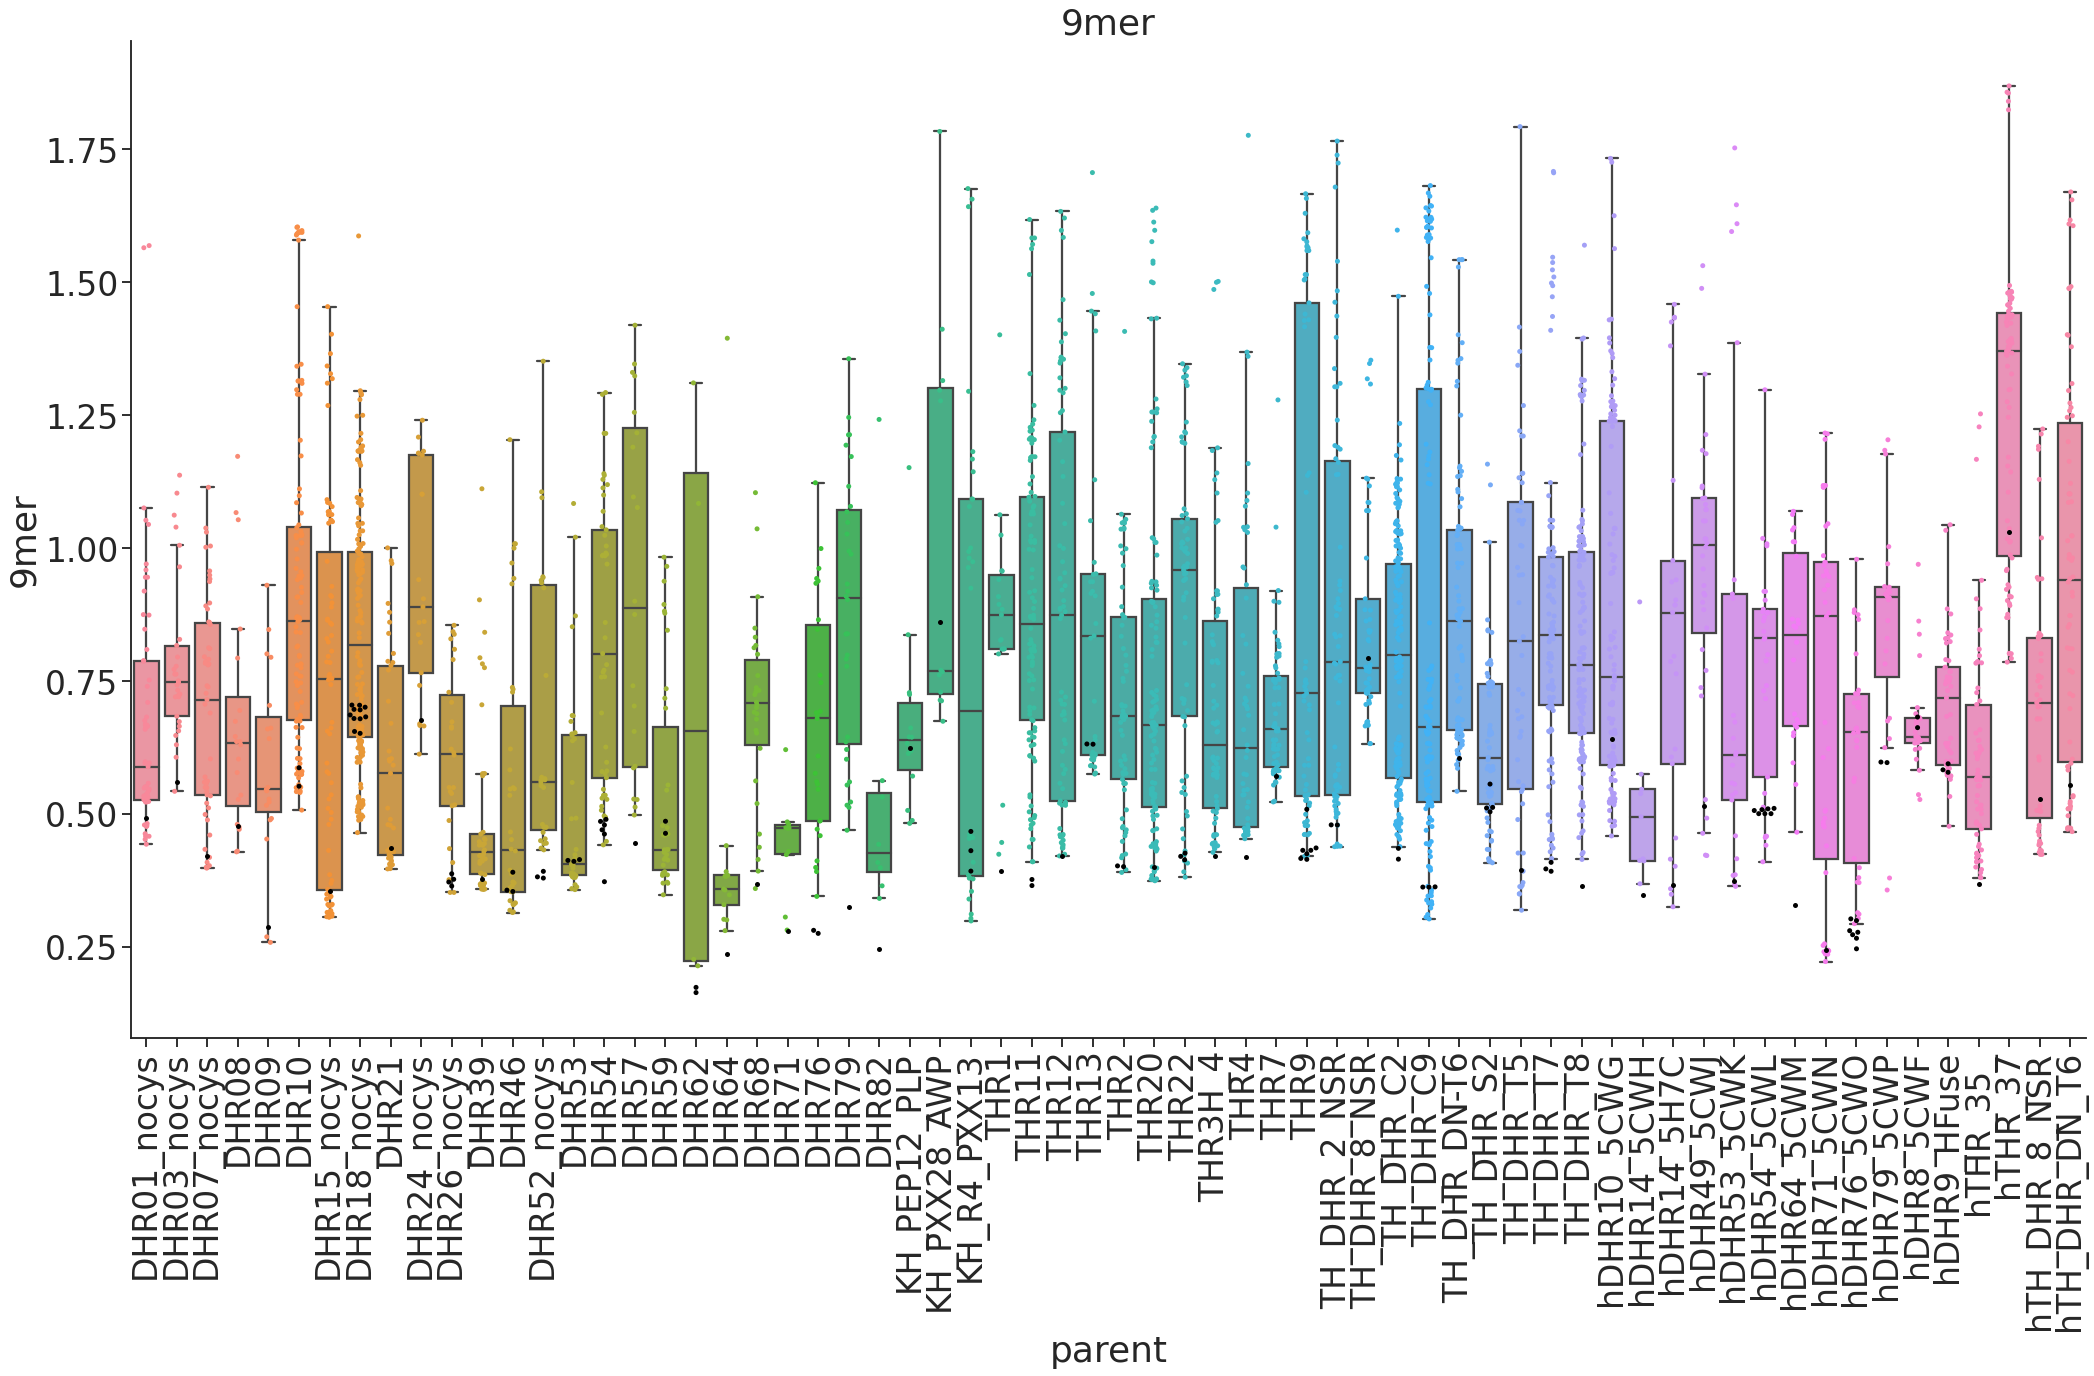

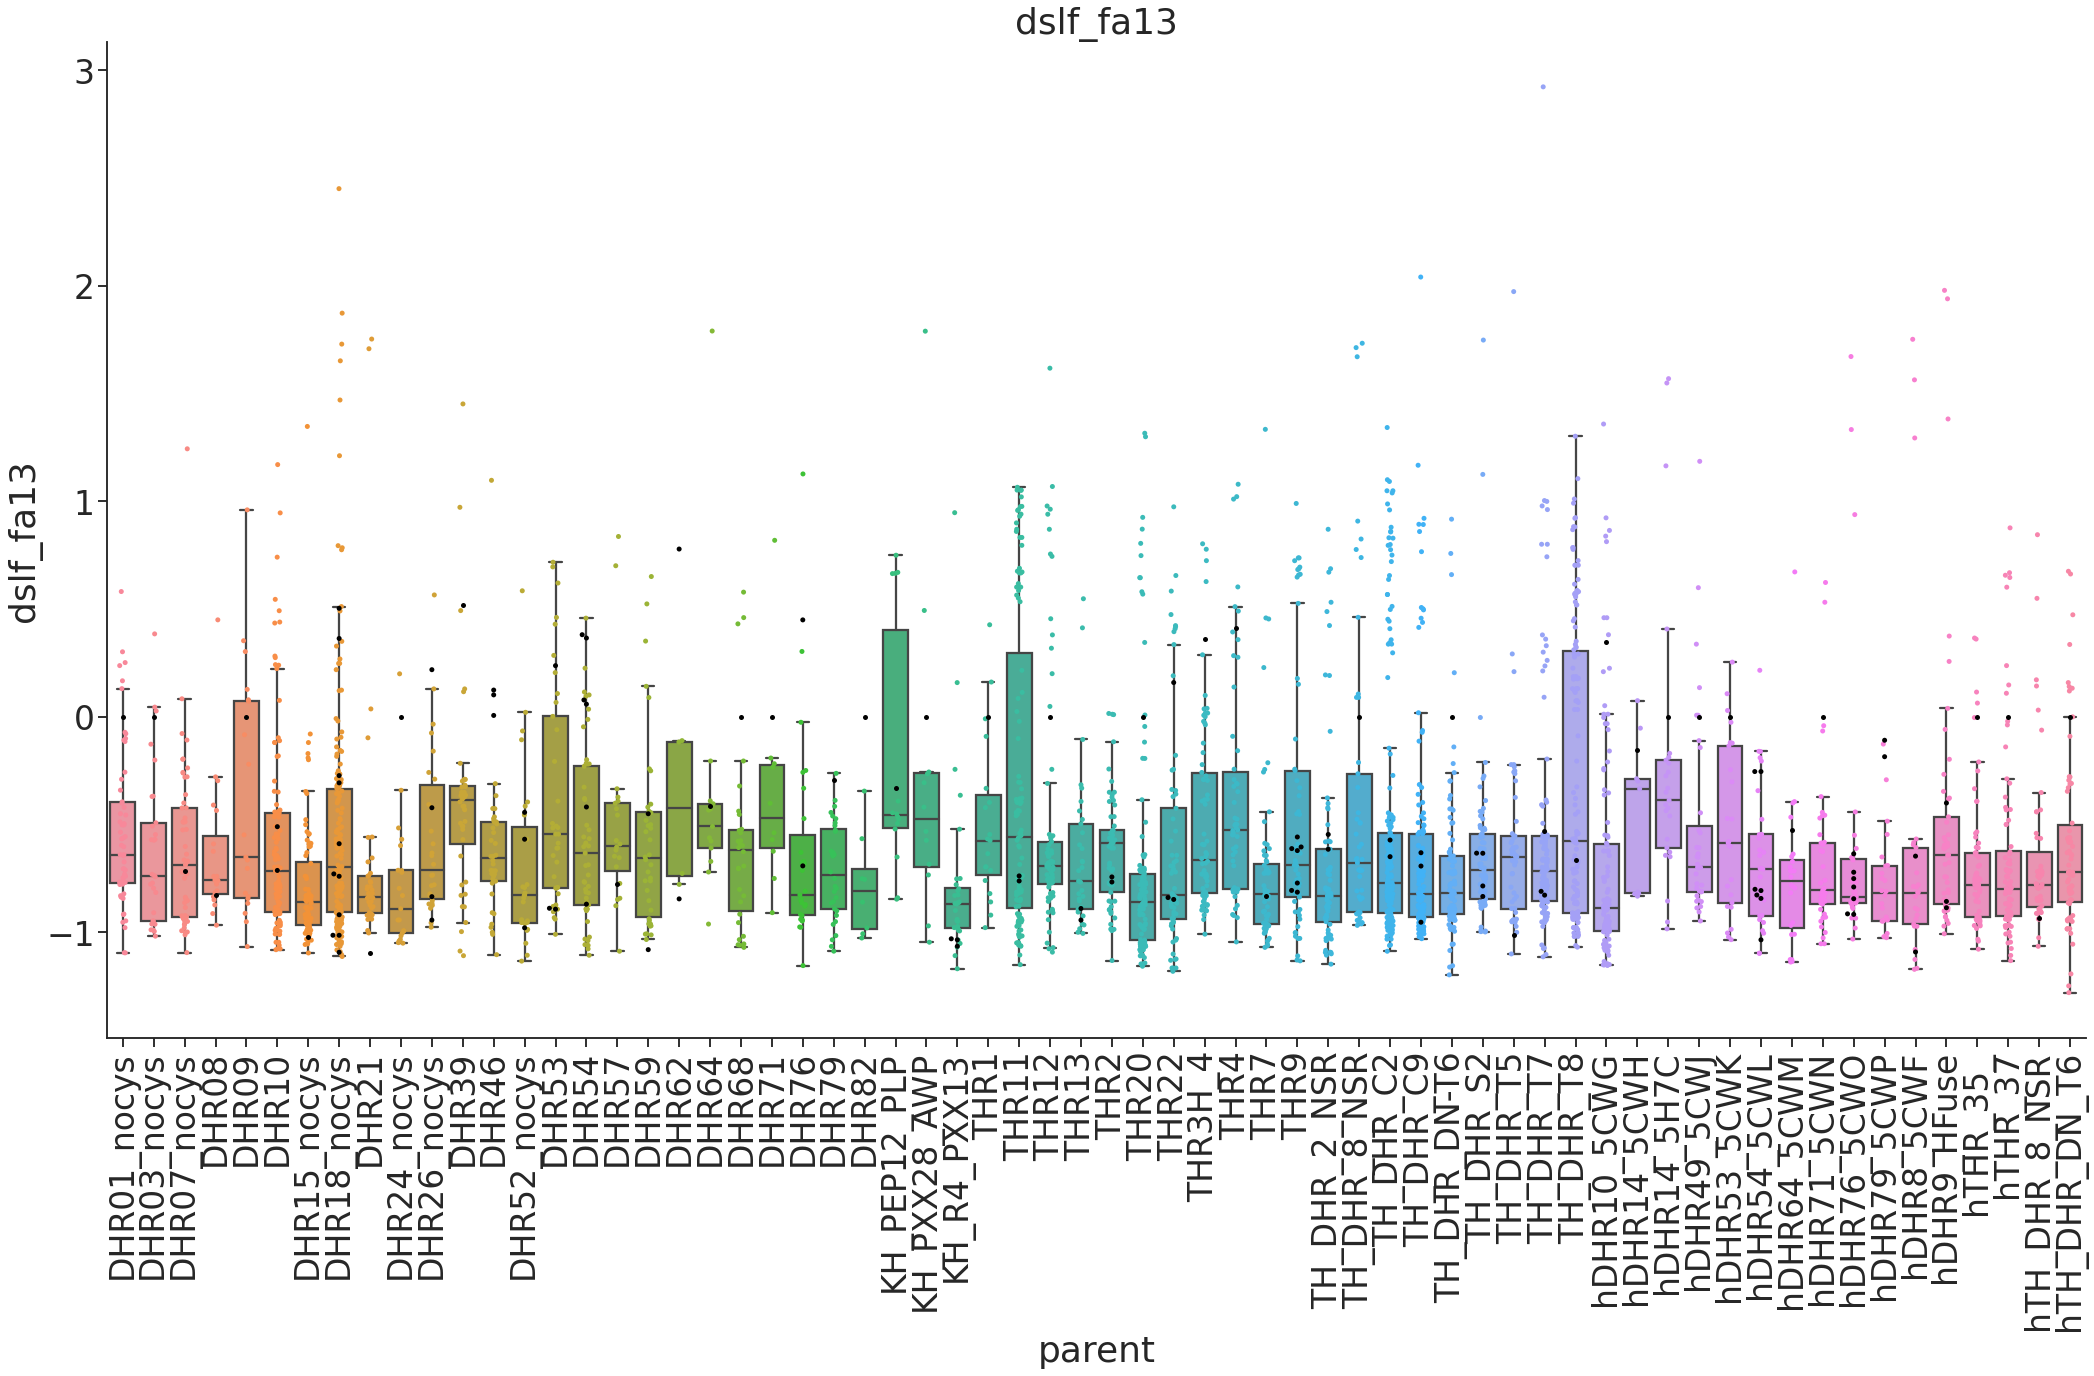

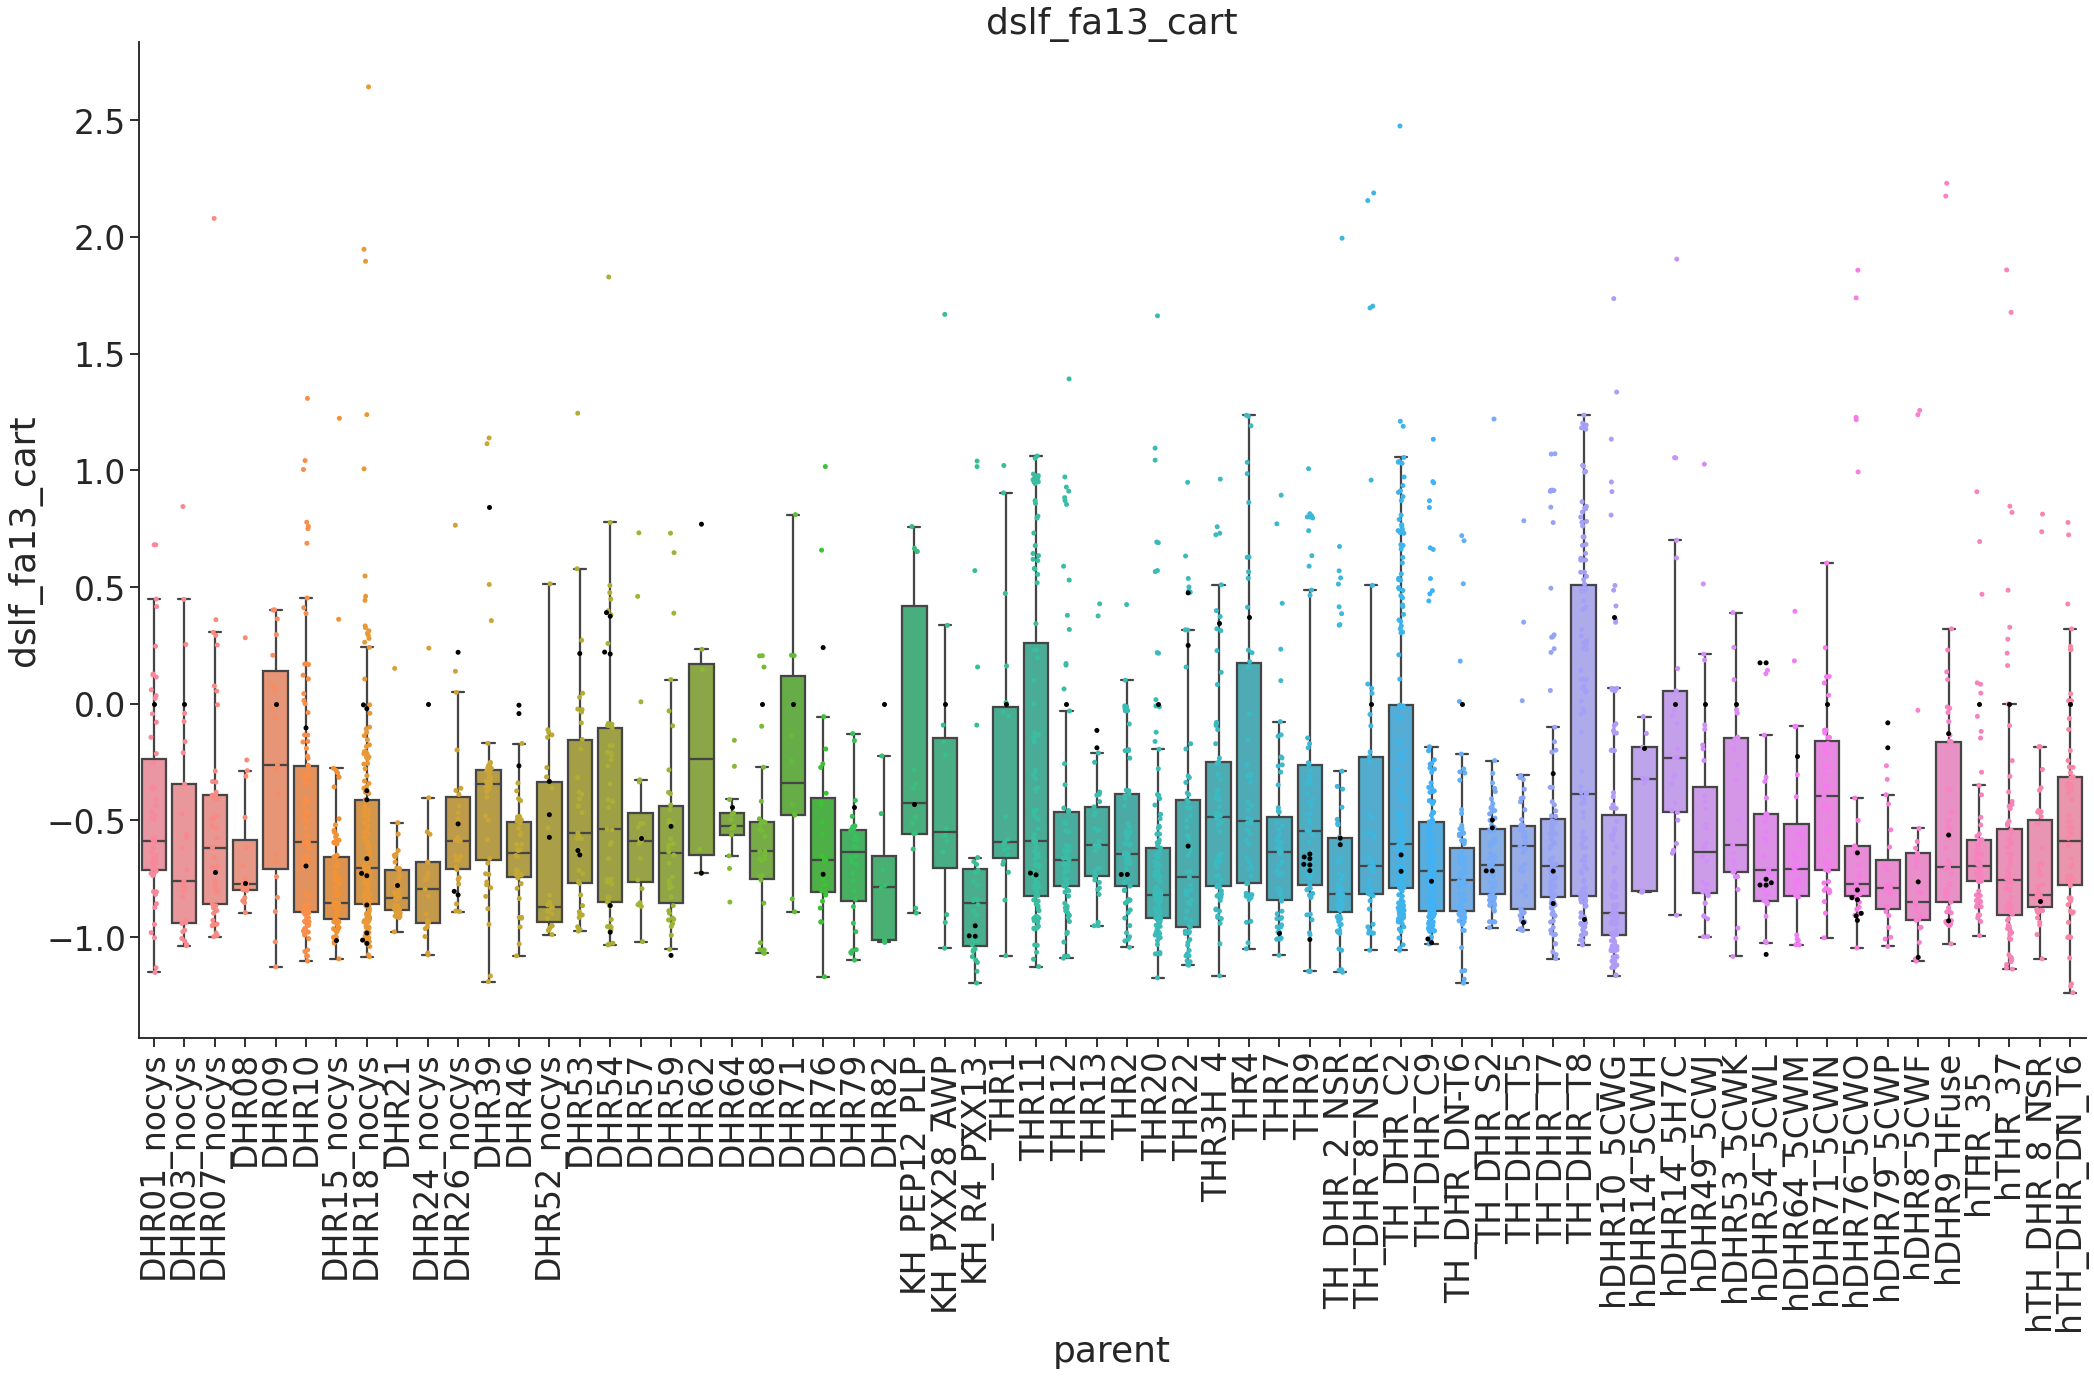

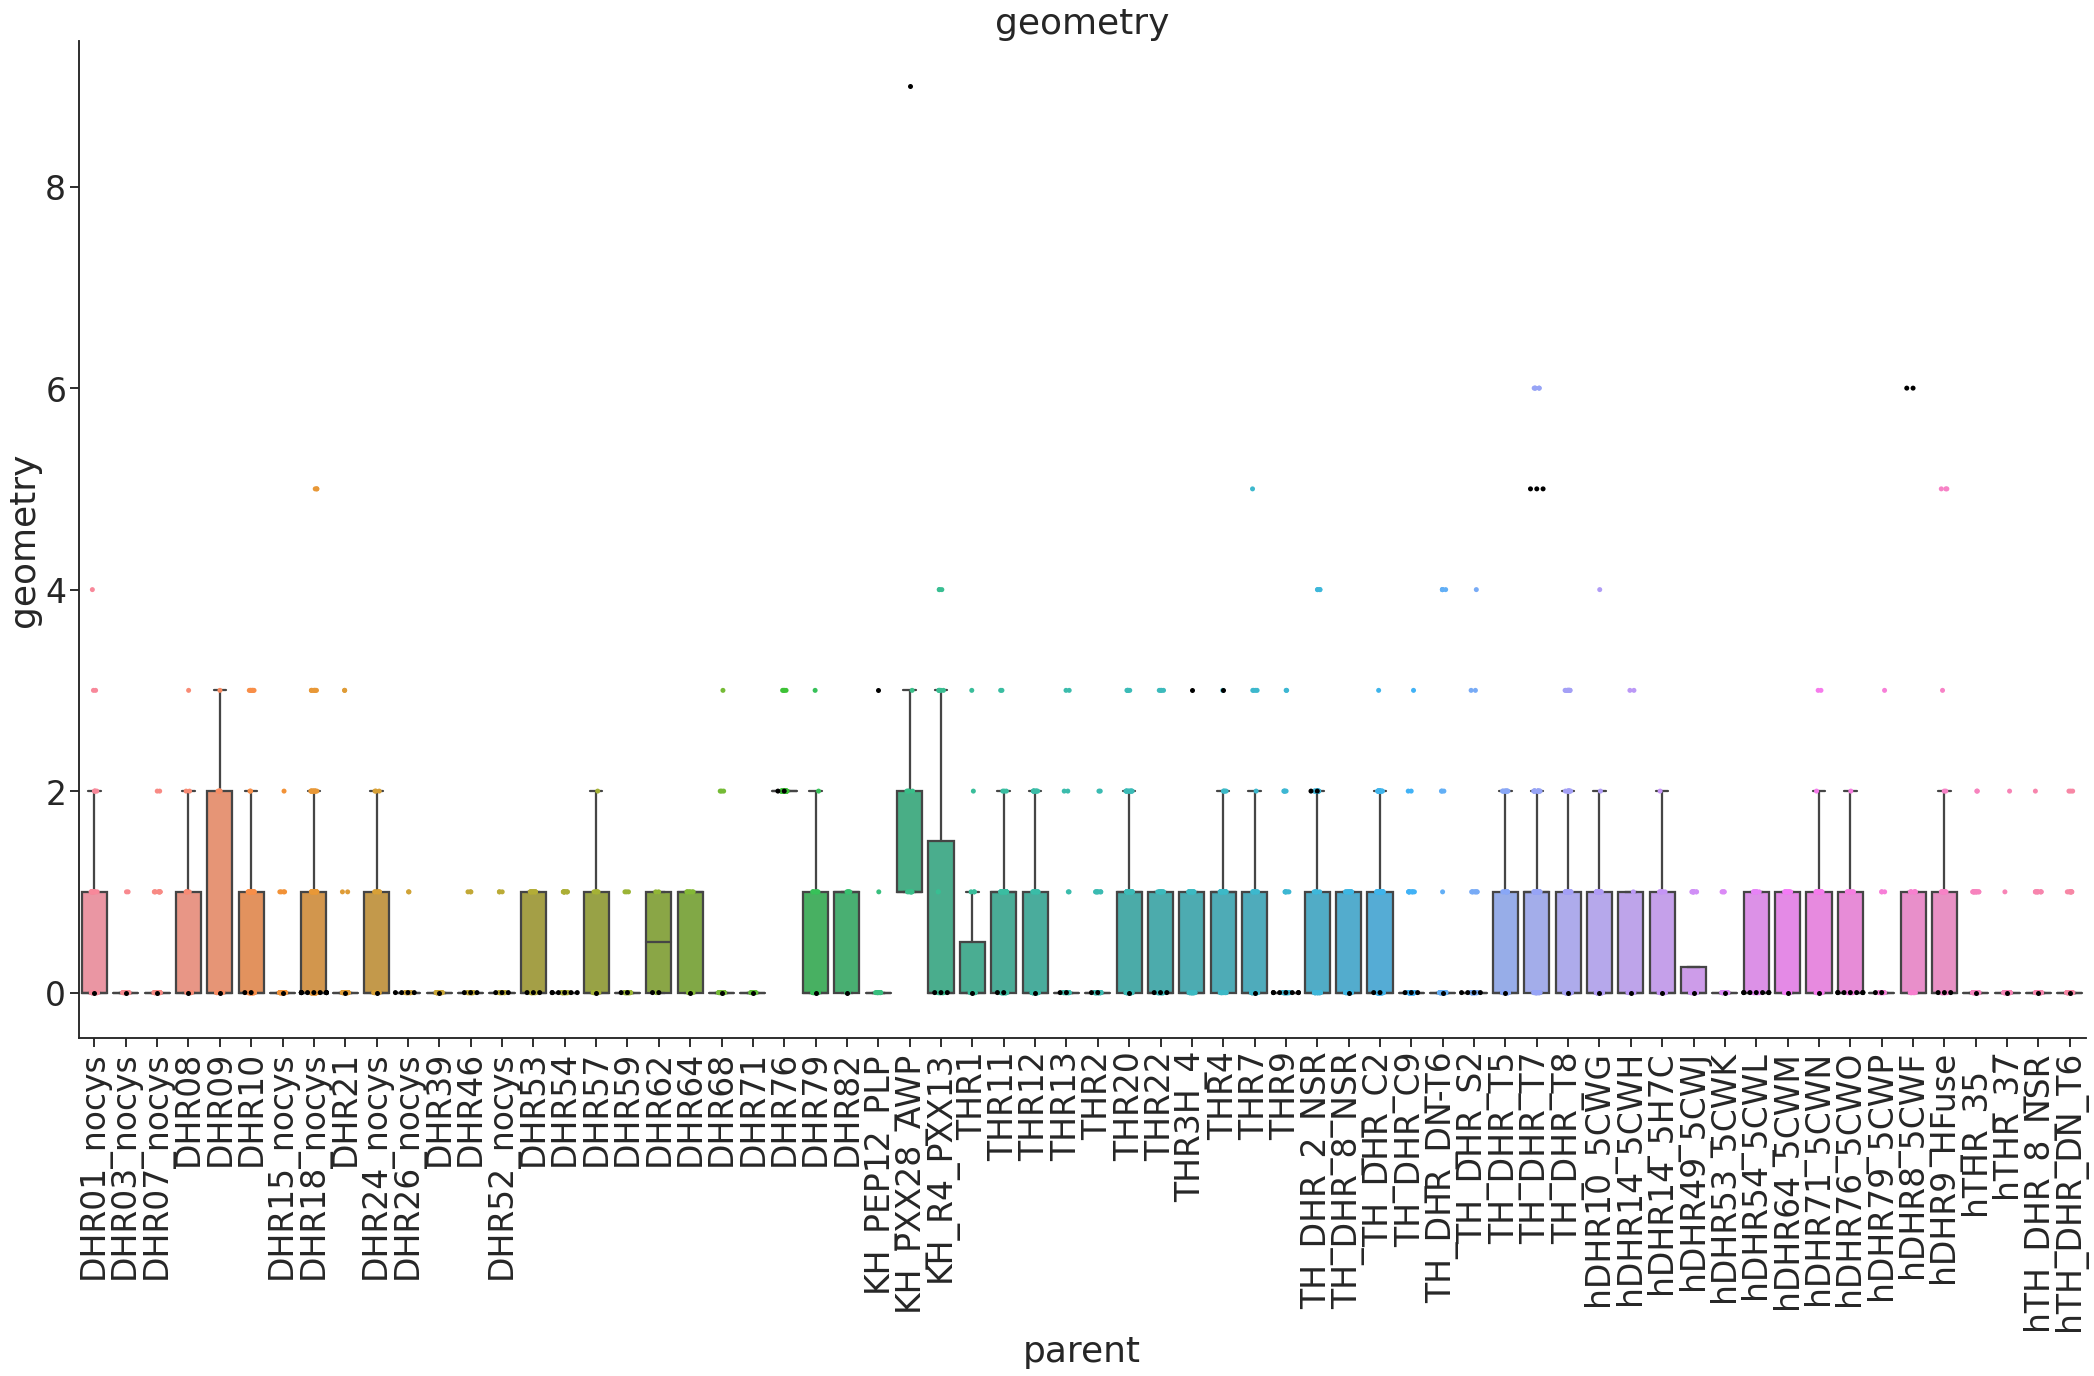

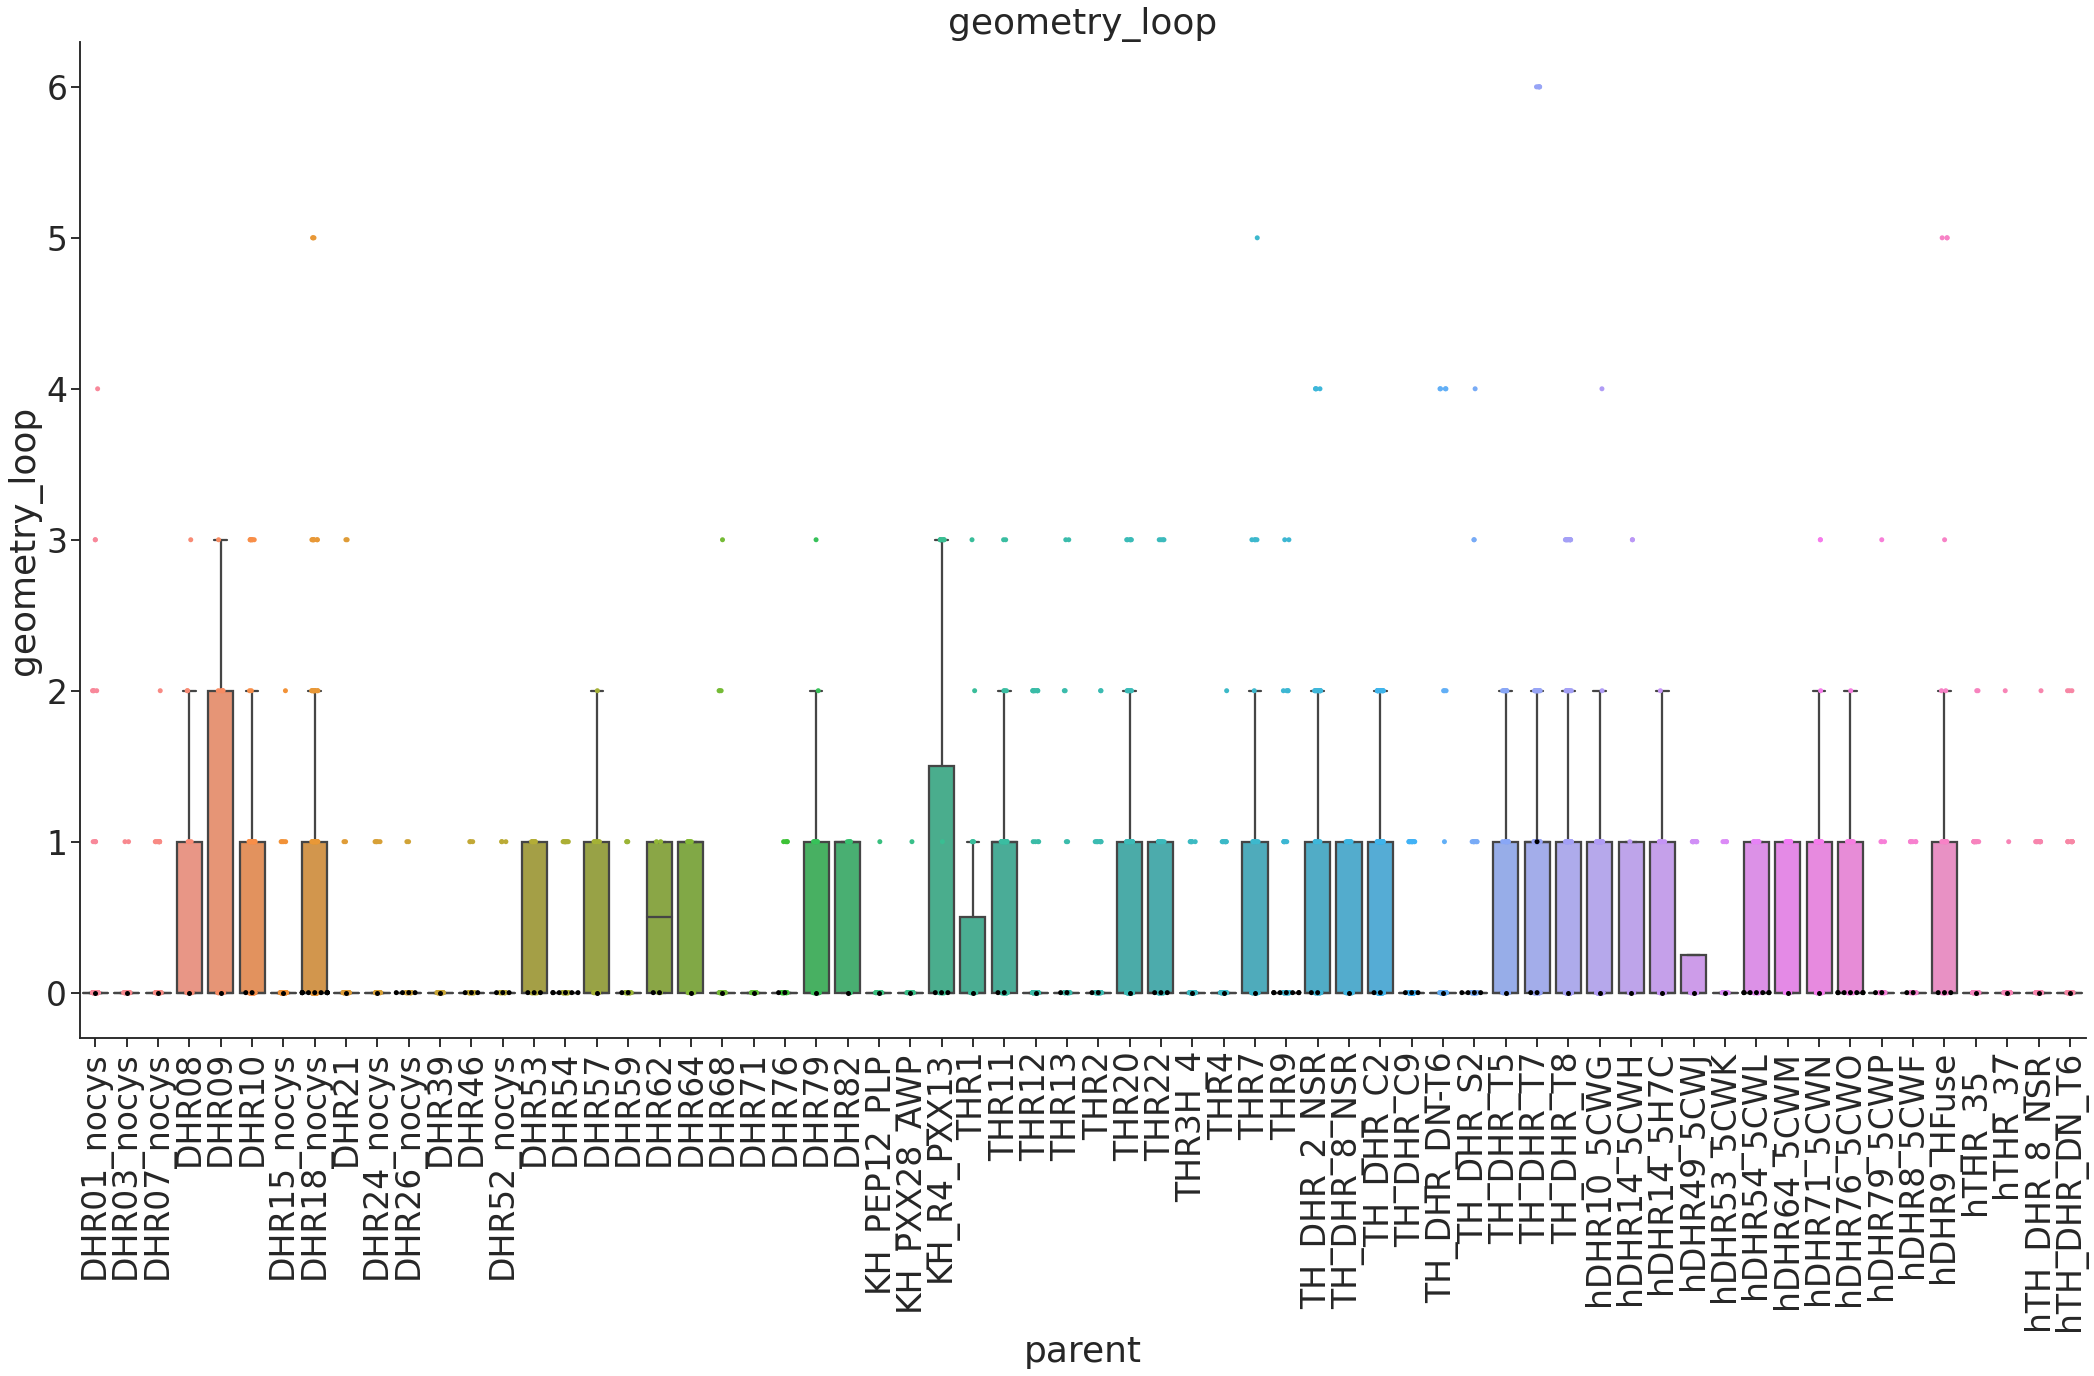

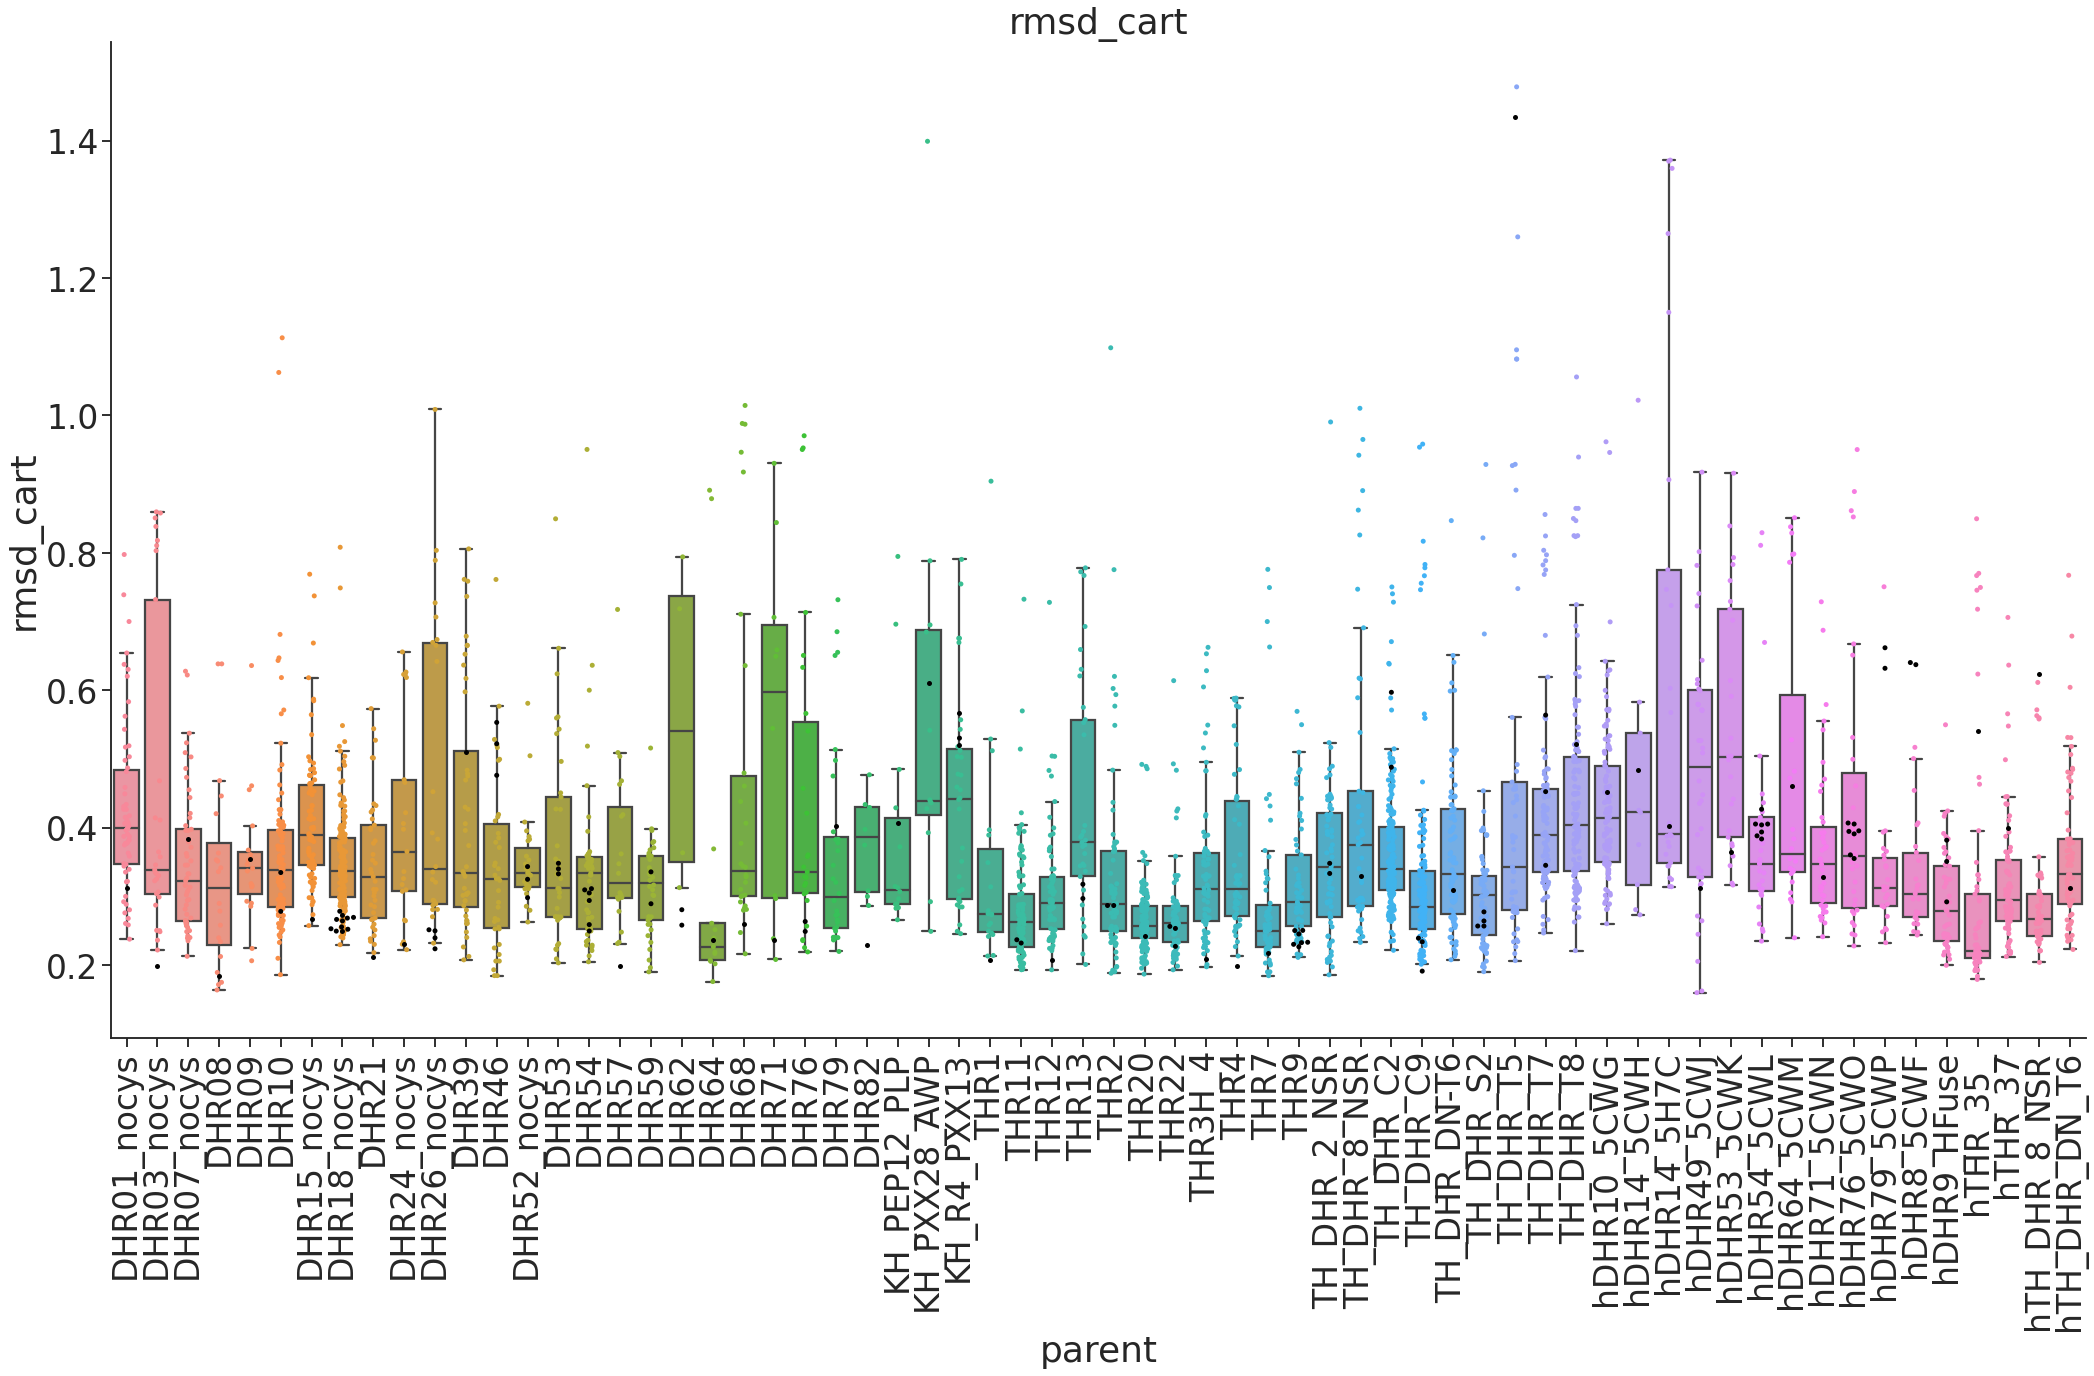

In [50]:
terms = [
        "9mer",
        "dslf_fa13",
        "dslf_fa13_cart",
        "geometry",
        "geometry_loop",
        "rmsd_cart",        
    ]
score_subset = scores_df[terms+["parent"]]

score_subset = score_subset[score_subset["9mer"] < 5] # don't want to plot the decoys with really bad 9mers
score_subset = score_subset[score_subset["dslf_fa13"] != 0] # don't want to plot the decoys with no disulfides
score_subset = score_subset[score_subset["dslf_fa13"] < 3] # don't want to plot the decoys with really bad disulfides
score_subset = score_subset[score_subset["dslf_fa13_cart"] < 3] # don't want to plot the decoys with really bad disulfides
score_subset = score_subset[score_subset["rmsd_cart"] < 1.5] # don't want to plot the decoys with really bad disulfides

order = sorted(list(set(scores_df.parent.values)))

for term in terms:
    fig = plt.figure(figsize=(30,20), tight_layout=True)
    plt.xticks(rotation=90)
    sns.boxplot(
        x="parent", y=term, data=score_subset,
        showfliers = False, order=order,
    )
    sns.stripplot(
        x="parent", y=term, data=score_subset, order=order,
    )
    sns.swarmplot(
        x="parent", y=term, data=ref_df, color="black", order=order,
    )
    sns.despine()
    plt.title(term)
    plt.show()
    plt.close()
    fig.savefig("figs/04_all_parents_vs_{term}.png".format(term=term))

In [75]:
score_subset = scores_df
score_subset = score_subset[score_subset["9mer"] < 5] # don't want to plot the decoys with really bad 9mers
score_subset = score_subset[score_subset["dslf_fa13"] != 0] # don't want to plot the decoys with no disulfides
score_subset = score_subset[score_subset["dslf_fa13"] < 3] # don't want to plot the decoys with really bad disulfides
score_subset = score_subset[score_subset["dslf_fa13_cart"] < 3] # don't want to plot the decoys with really bad disulfides
score_subset = score_subset[score_subset["rmsd_dual"] < 20] # i messed this up
score_subset = score_subset[score_subset["rmsd_cart"] < 1.5] # don't want to plot the decoys with really bad disulfides

print(len(score_subset))

score_subset.groupby("shift").size()

3454


shift
-7.0    164
-6.0    111
-5.0    362
-4.0    267
-3.0    131
-2.0     66
-1.0    218
 0.0    906
 1.0    212
 2.0     18
 3.0    178
 4.0    229
 5.0    290
 6.0    130
 7.0    172
dtype: int64

In [76]:
score_subset.groupby("parent").size()

parent
DHR01_nocys      59
DHR03_nocys      29
DHR07_nocys      53
DHR08            20
DHR09            19
                 ..
hDHR9_HFuse      49
hTHR_35_         65
hTHR_37          84
hTH_DHR_8_NSR    51
hTH_DHR_DN_T6    70
Length: 64, dtype: int64

In [80]:
score_subset = score_subset[score_subset["dslf_fa13"] < -0.8]
score_subset = score_subset[score_subset["rmsd_cart"] < 0.5]
score_subset = score_subset[score_subset["shift"] != 0.0]

print(len(score_subset))

score_subset.groupby("shift").size()

1013


shift
-7.0     81
-6.0     23
-5.0    146
-4.0    137
-3.0     44
-2.0     24
-1.0     74
 1.0     69
 2.0      8
 3.0     67
 4.0     85
 5.0    112
 6.0     47
 7.0     96
dtype: int64

In [81]:
score_subset.groupby("parent").size()


parent
DHR01_nocys       9
DHR03_nocys       8
DHR07_nocys      12
DHR08             1
DHR09             6
DHR10            39
DHR15_nocys      35
DHR18_nocys      41
DHR21             7
DHR24_nocys      10
DHR39             3
DHR46             1
DHR52_nocys       3
DHR53             7
DHR54            14
DHR59             6
DHR64             1
DHR68             9
DHR76             8
DHR79            10
DHR82             4
KH_R4_PXX13       6
THR1              1
THR11            42
THR12            15
THR13             7
THR2             14
THR20            53
THR22            31
THR3H_4          15
THR4             13
THR7             22
THR9             18
TH_DHR_2_NSR     38
TH_DHR_8_NSR      9
TH_DHR_C2        77
TH_DHR_C9        63
TH_DHR_DN-T6     47
TH_DHR_S2        26
TH_DHR_T5        13
TH_DHR_T7        26
TH_DHR_T8        34
hDHR10_5CWG      48
hDHR14_5H7C       2
hDHR49_5CWJ       3
hDHR53_5CWK       4
hDHR54_5CWL       5
hDHR64_5CWM       7
hDHR71_5CWN      16
hDHR76_5CWO  

In [73]:
scores_df["state"] = scores_df["parent"] + "__" + scores_df["shift"].astype(int).astype(str) + "__" + scores_df["pivot_helix"].astype(int).astype(str) #.astype(int).astype(str).apply(lambda x: )

# df[term] = df[term].astype(float).astype(int).astype(str)

In [74]:
scores_df.groupby("state").size()

state
DHR01_nocys__-3__4      7
DHR01_nocys__-3__5      8
DHR01_nocys__-4__5      5
DHR01_nocys__-7__5      1
DHR01_nocys__0__4       6
                       ..
hTH_DHR_DN_T6__4__4     5
hTH_DHR_DN_T6__4__5     4
hTH_DHR_DN_T6__5__4     9
hTH_DHR_DN_T6__5__5    10
hTH_DHR_DN_T6__7__4     4
Length: 769, dtype: int64

In [82]:
score_subset.groupby("state").size()

state
DHR01_nocys__-3__4     3
DHR01_nocys__-4__5     2
DHR01_nocys__1__5      2
DHR01_nocys__5__5      2
DHR03_nocys__-4__4     4
                      ..
hTH_DHR_DN_T6__1__5    2
hTH_DHR_DN_T6__4__4    2
hTH_DHR_DN_T6__5__4    1
hTH_DHR_DN_T6__5__5    4
hTH_DHR_DN_T6__7__4    4
Length: 249, dtype: int64

In [83]:
set(scores_df.parent.values) - set(score_subset.parent.values)

{'DHR26_nocys',
 'DHR57',
 'DHR62',
 'DHR71',
 'KH_PEP12_PLP',
 'KH_PXX28_AWP',
 'hDHR14_5CWH'}

# TODO
check rmsd between pre/post nmp
make pairs functions
make rmsd after force disulfide function
more plots/analysis
start nb 5_two_state